# Data Investigation - Trip Data

### Import Data

In [2]:
%matplotlib inline

import matplotlib
import numpy as np
from scipy import stats
import scipy
import math
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import datetime

import seaborn as sns
sns.set()

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

font = {'size'   : 50}
matplotlib.rc('font', **font)

LABEL_FONT_SIZE = 15
TITLE_FONT_SIZE = 25

# Load Trip Data

In [4]:
print('[%s] Loading Trip Data Data...' % datetime.datetime.now().time())
try:
    trip_data = pd.DataFrame()
    trip_data_file = '../clean_data/trip_data_cleaned_master.csv'

    # Chunk Settings
    chunks = []
    chunk_counter = 1
    chunksize = 10000
    num_chunks = math.ceil(sum(1 for row in open(trip_data_file, 'r'))/chunksize)

    # import file in chunks
    for chunk in pd.read_csv(trip_data_file, chunksize=chunksize, iterator=True, index_col=0, parse_dates=['start_date', 'end_date']):

    #         # define Columns
    #         chunk.columns = ['trip_id', 'duration', 'start_date', 'start_station_name', 'start_terminal', 'end_date', 
    #                          'end_station_name', 'end_terminal', 'bike_id', 'subscriber_type', 'zip_code']

        # append chunk to chunks list
        chunks.append(chunk)

        if chunk_counter == 1 or chunk_counter % math.ceil(num_chunks/10) == 0 or chunk_counter == num_chunks:
            print('\t\t[%s] finished chunk %s of %s' % (datetime.datetime.now().time(), chunk_counter, num_chunks))
        chunk_counter += 1
    
    trip_data = pd.concat(chunks)

    print('[%s] Complete!' % datetime.datetime.now().time())

except:
    print('oops... something went wrong importing the data :(')
    


[23:10:38.650645] Loading Trip Data Data...
		[23:10:39.438749] finished chunk 1 of 96
		[23:10:40.444950] finished chunk 10 of 96
		[23:10:41.450276] finished chunk 20 of 96
		[23:10:42.430111] finished chunk 30 of 96
		[23:10:43.409515] finished chunk 40 of 96
		[23:10:44.393773] finished chunk 50 of 96
		[23:10:45.472072] finished chunk 60 of 96
		[23:10:46.513665] finished chunk 70 of 96
		[23:10:47.549701] finished chunk 80 of 96
		[23:10:48.575656] finished chunk 90 of 96
		[23:10:49.124236] finished chunk 96 of 96
[23:10:49.750641] Complete!


In [5]:
trip_data.head(5)

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,user_type,...,end_zip,max_temp,mean_temp,min_temp,max_wind,mean_wind,max_gust,precipitation,cloud_cover,events
0,4069,174,2013-08-29 09:08:00,2nd at South Park,64,2013-08-29 09:11:00,2nd at South Park,64,288,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
1,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
2,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
3,4075,1117,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,316,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
4,4076,1118,2013-08-29 09:25:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,322,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN


In [6]:
trip_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 955557 entries, 0 to 955556
Data columns (total 25 columns):
trip_id               955557 non-null int64
duration              955557 non-null int64
start_date            955557 non-null datetime64[ns]
start_station_name    955557 non-null object
start_terminal        955557 non-null int64
end_date              955557 non-null datetime64[ns]
end_station_name      955557 non-null object
end_terminal          955557 non-null int64
bike_id               955557 non-null int64
user_type             955557 non-null object
user_zip              955557 non-null int64
duration_minutes      955557 non-null float64
start_area            955557 non-null object
end_area              955557 non-null object
start_zip             955557 non-null int64
end_zip               955557 non-null int64
max_temp              955507 non-null float64
mean_temp             955507 non-null float64
min_temp              955507 non-null float64
max_wind              

## Utility Functions

In [183]:
day_labels = ['MON','TUE','WED','THU','FRI','SAT','SUN']
day_labels_full = ['MONDAY','TUESDAY','WEDNESDAY','THURSDAY','FRIDAY','SATURDAY','SUNDAY']
month_labels = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']

zip_lookup = {
    94107 : 'San Francisco',
    94063 : 'Redwood City',
    94301 : 'Palo Alto',
    94041 : 'Mountain View',
    95113 : 'San Jose'
}

# Goal 1 - Identify Key User Groups

- All Users
    - Customers
    - Subscribers

In [8]:
# Separate Customer Data and SUbscriber Data
customer_trip_data = trip_data[trip_data.user_type == 'Customer'].copy()
subscriber_trip_data = trip_data[trip_data.user_type == 'Subscriber'].copy()

print('Desription\t\t\tTrip Count\tShare')
print('Total Trips Records\t\t%s' % len(trip_data))
print('Total Subscriber Trip Records\t%s\t\t%0.2f' % (len(subscriber_trip_data), len(subscriber_trip_data)/len(trip_data)*100.))
print('Total Customer Trip Records\t%s\t\t%0.2f' % (len(customer_trip_data), len(customer_trip_data)/len(trip_data)*100.))


Desription			Trip Count	Share
Total Trips Records		955557
Total Subscriber Trip Records	844570		88.39
Total Customer Trip Records	110987		11.61


# Goal 2 - Identify Usage Patterns for User Groups

> We have two key user groups, what are the similarities and difference of their ussage?
- Subscribers
    - Hour of the Day - Two Distinct peaks, during commute hours
    - Day of the Week - Weekday Trips out number Weekend Trips nearly 5 to 1
    - Month of the Year - Rougly 35% dip in November into December, remainder of year steady
- Commuters
    - Hour of the Day - Nice Even lump during daylight hours 8am-7pm
    - Day of the Week - Weekends are busiest, but not by much
    - Month of the Year - Peak in September, busiest in Summer months
    
> How do these groups compare by volume?
- Subscribers make up 88.39% of all Trips
    - 78% of all Subscriber trips are during commuting hours


In [9]:
x_ticks = sorted(pd.unique(trip_data.start_date.dt.hour))
subscriber_y = trip_data[trip_data.user_type == 'Subscriber'].groupby(trip_data.start_date.dt.hour)['trip_id'].count()
customer_y   = trip_data[trip_data.user_type == 'Customer'].groupby(trip_data.start_date.dt.hour)['trip_id'].count()
sub_norm  = subscriber_y.to_frame().apply(lambda x: x / (np.max(x) - np.min(x)))
cust_norm =   customer_y.to_frame().apply(lambda x: x / (np.max(x) - np.min(x)))

### Distribution by User Type

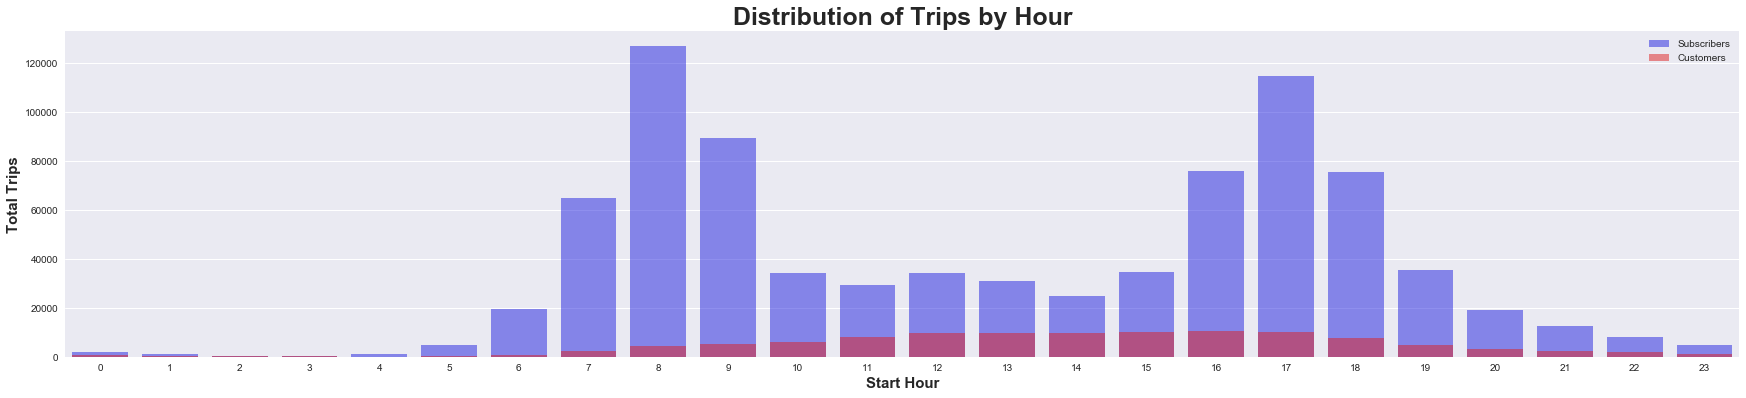

In [10]:
plt.subplots(figsize=(30,6))
ax = sns.barplot(x = x_ticks , y = subscriber_y, color='b', alpha = 0.5, label='Subscribers')
sns.barplot(x = x_ticks , y = customer_y, color='r', alpha = 0.5, label='Customers', ax=ax)

ax.set_title('Distribution of Trips by Hour', size=TITLE_FONT_SIZE, weight='bold')
ax.set_xlabel('Start Hour', size=LABEL_FONT_SIZE, weight='bold')
ax.set_ylabel('Total Trips', size=LABEL_FONT_SIZE, weight='bold')
ax.set_xticks(x_ticks)

plt.legend()
plt.show()

In [16]:
y_max = trip_data[trip_data.user_type == 'Subscriber'].groupby(trip_data.start_date.dt.hour)['trip_id'].count().max()

y_max = int(math.ceil(y_max / 100000) * 100000)
y_step = int(y_max / 10)
y_ticks = range(0, y_max, y_step)

In [97]:
def plot_trip_distributions(user_type = 'Subscriber', color='b', h_step=10000, d_step=25000, m_step=10000):
    
    def draw_plot(x, y, title, x_label, y_label, x_tick_labels, y_step):

        plt.subplots(figsize=(15,6))
        ax = sns.barplot(x = x, 
                         y = y, 
                         color = color, 
                         alpha = 0.5, 
                         label=user_type)

        ax.set_title('Distribution of Trips by Hour', size=TITLE_FONT_SIZE, weight='bold')
        

        ax.set_xlabel(x_label, size=LABEL_FONT_SIZE, weight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(x_tick_labels)

        y_max = int(math.ceil(y.max() / y_step) * y_step) + y_step
        y_ticks = range(0, y.max()+y_step, y_step)

        ax.set_ylabel(y_label, size=LABEL_FONT_SIZE, weight='bold')
        ax.set_yticks(y_ticks)

        plt.legend()
        plt.show()
     
    # Draw Trips by Hour of Day
    draw_plot(x = x_ticks, 
              y = trip_data[trip_data.user_type == user_type].groupby(trip_data.start_date.dt.hour)['trip_id'].count(), 
              title = 'Distribution of Trips by Hour', 
              x_label = 'Hour', 
              y_label = 'Trip Count', 
              x_tick_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
                               '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
                               '21', '22', '23'],
              y_step = h_step)

    
    
    # Draw Trips by Day of Week
    weekday_map= {0:'MON', 1:'TUE', 2:'WED', 3:'THU',
                  4:'FRI', 5:'SAT', 6:'SUN'}
    
    draw_plot(x = sorted(pd.unique(trip_data.start_date.dt.dayofweek)), 
              y = trip_data[trip_data.user_type == user_type].groupby(trip_data.start_date.dt.dayofweek)['trip_id'].count(), 
              title = 'Distribution of Trips by Day of Week', 
              x_label = 'Day of Week', 
              y_label = 'Trip Count', 
              x_tick_labels = [weekday_map[d] for d in sorted(pd.unique(trip_data.start_date.dt.dayofweek))],
              y_step = d_step)

    # Draw Trips by Month of Year
    month_map = {1:'JAN', 2:'FEB', 3:'MAR', 4:'APR', 
                 5:'MAY', 6:'JUN', 7:'JUL', 8:'AUG', 
                 9:'SEP', 10:'OCT', 11:'NOV', 12:'DEC'}


    draw_plot(x = sorted(pd.unique(trip_data.start_date.dt.month)), 
              y = trip_data[trip_data.user_type == user_type].groupby(trip_data.start_date.dt.month)['trip_id'].count(), 
              title = 'Distribution of Trips by Hour', 
              x_label = 'Month', 
              y_label = 'Trip Count', 
              x_tick_labels = [month_map[d] for d in sorted(pd.unique(trip_data.start_date.dt.month))],
              y_step = m_step)

### Subscriber Distribution

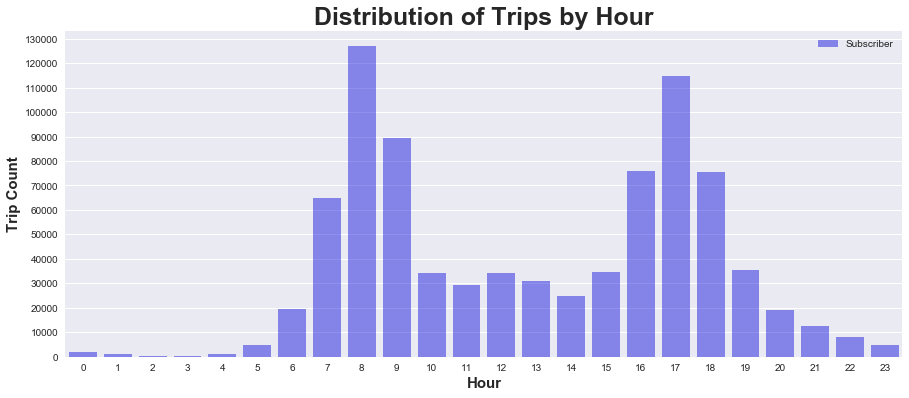

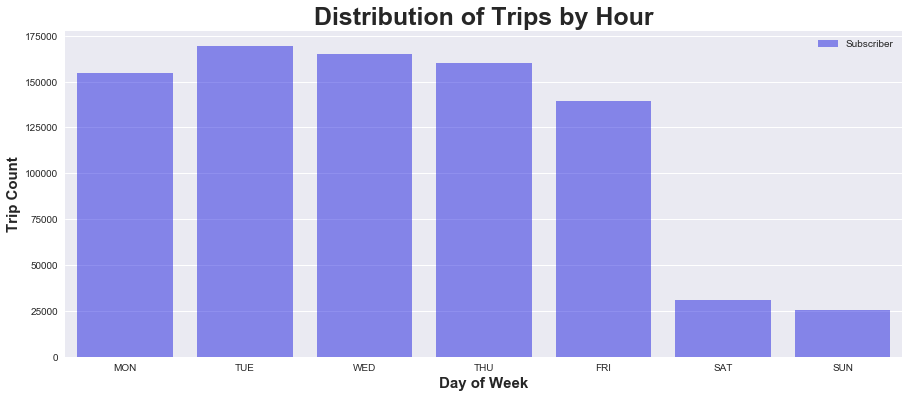

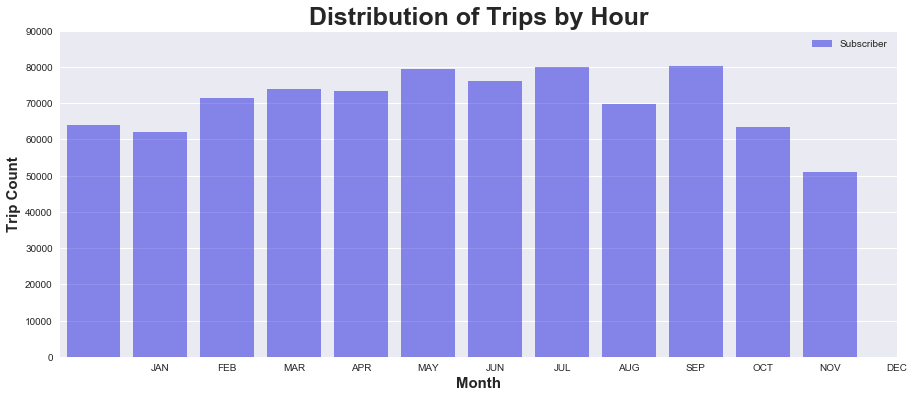

In [101]:
plot_trip_distributions(user_type = 'Subscriber', color='b', h_step=10000, d_step=25000, m_step=10000)

### Customer Distribution

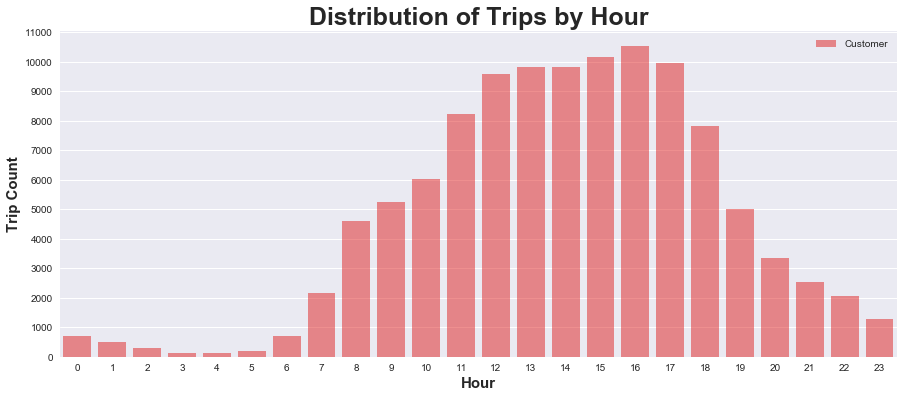

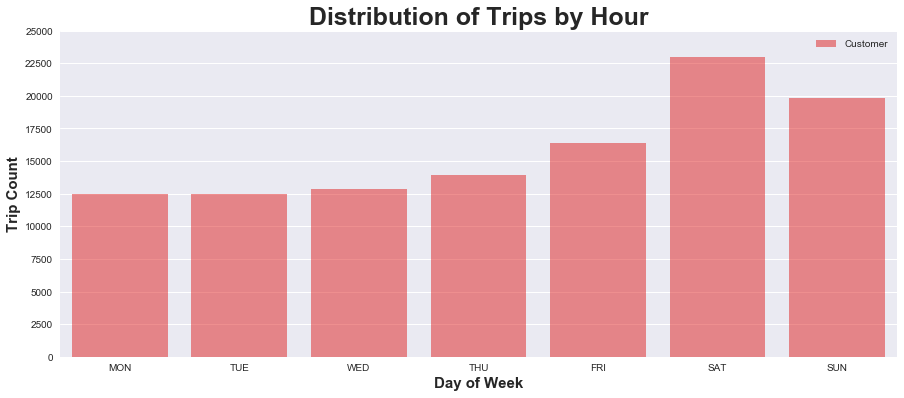

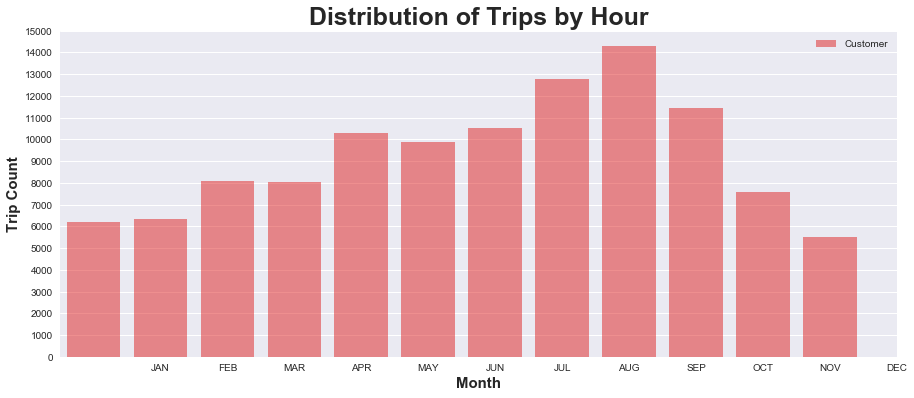

In [102]:
plot_trip_distributions(user_type = 'Customer', color='r', h_step=1000, d_step=2500, m_step=1000)

# Goal 3 - Identify Trends in Service Areas

> The Bay Area Bike Share Program serves 5 Metro Areas
- San Francisco
    - Identify Popular Terminals
    - Customers vs Subscribers
    
- San Jose
    - Identify Popular Terminals
    - Customers vs Subscribers

- Mountain View
    - Identify Popular Terminals
    - Customers vs Subscribers

- Palo Alto
    - Identify Popular Terminals
    - Customers vs Subscribers

- Redwood City
    - Identify Popular Terminals
    - Customers vs Subscribers

    
    
    
> How do these groups compare by volume?
- Subscribers make up 88.39% of all Trips
    - 78% of all Subscriber trips are during commuting hours



### Subscriber Terminal Usage

In [171]:
subscriber_terminal_usage = trip_data[trip_data.user_type == 'Subscriber'].copy()

# select only trips that start and end in same zip code
regonalized_subscriber_terminal_usage = subscriber_terminal_usage[subscriber_terminal_usage.start_zip == subscriber_terminal_usage.end_zip].copy()
non_regonalized_subscriber_terminal_usage = subscriber_terminal_usage[subscriber_terminal_usage.start_zip != subscriber_terminal_usage.end_zip].copy()

print('regonalized_subscriber_terminal_usage\t\t', len(regonalized_subscriber_terminal_usage))
print('non_regonalized_subscriber_terminal_usage\t', len(non_regonalized_subscriber_terminal_usage))

regonalized_subscriber_terminal_usage		 843880
non_regonalized_subscriber_terminal_usage	 690


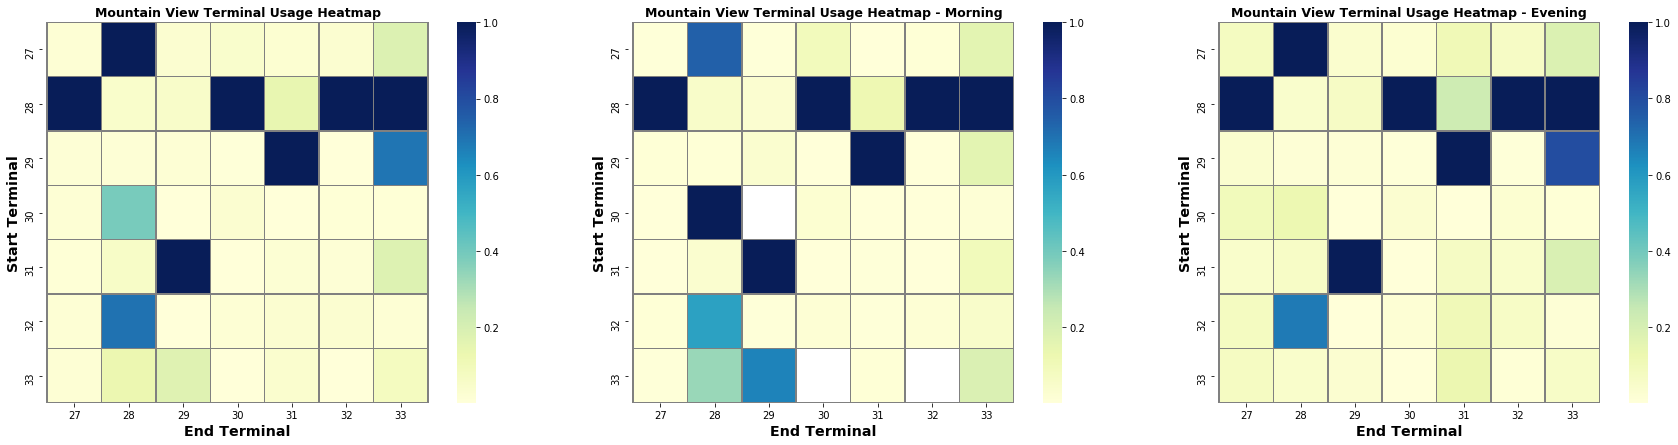

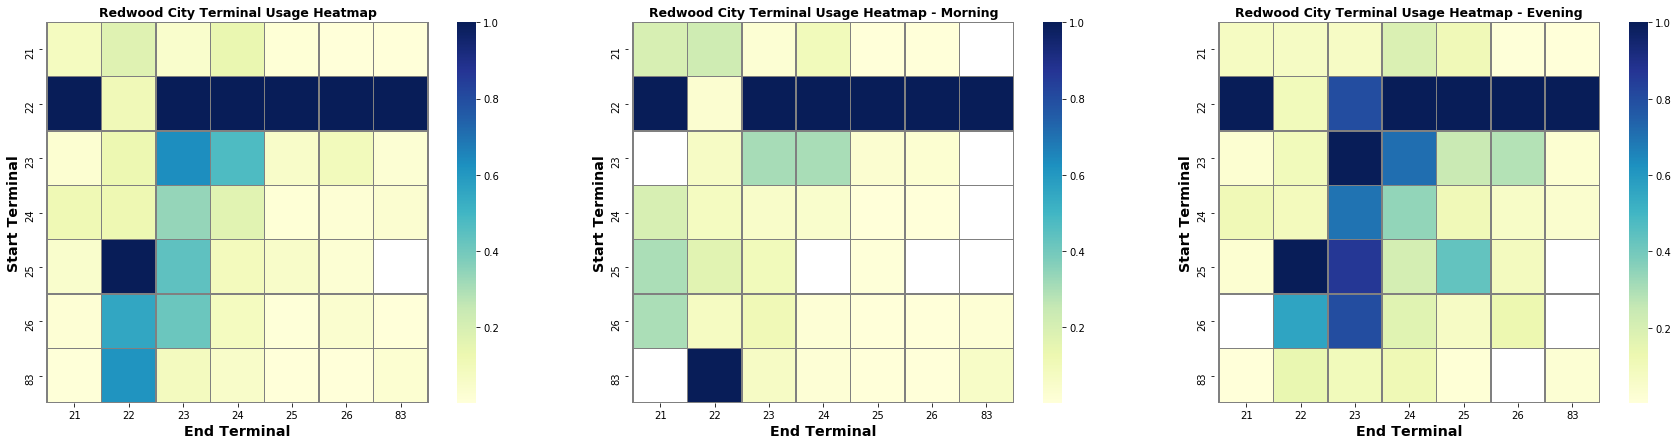

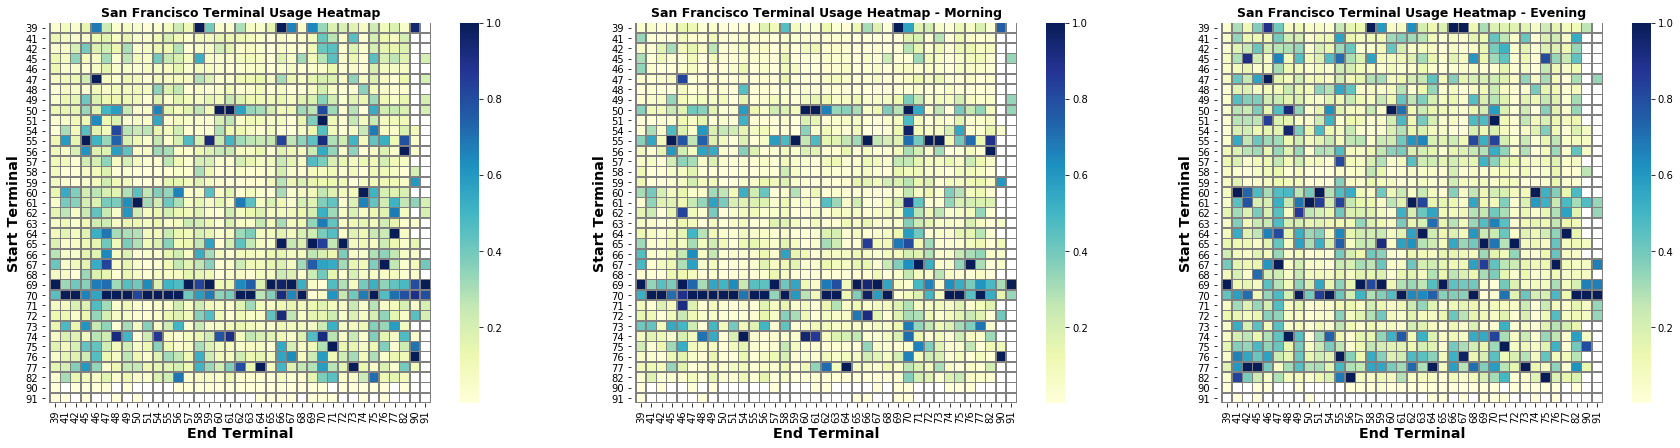

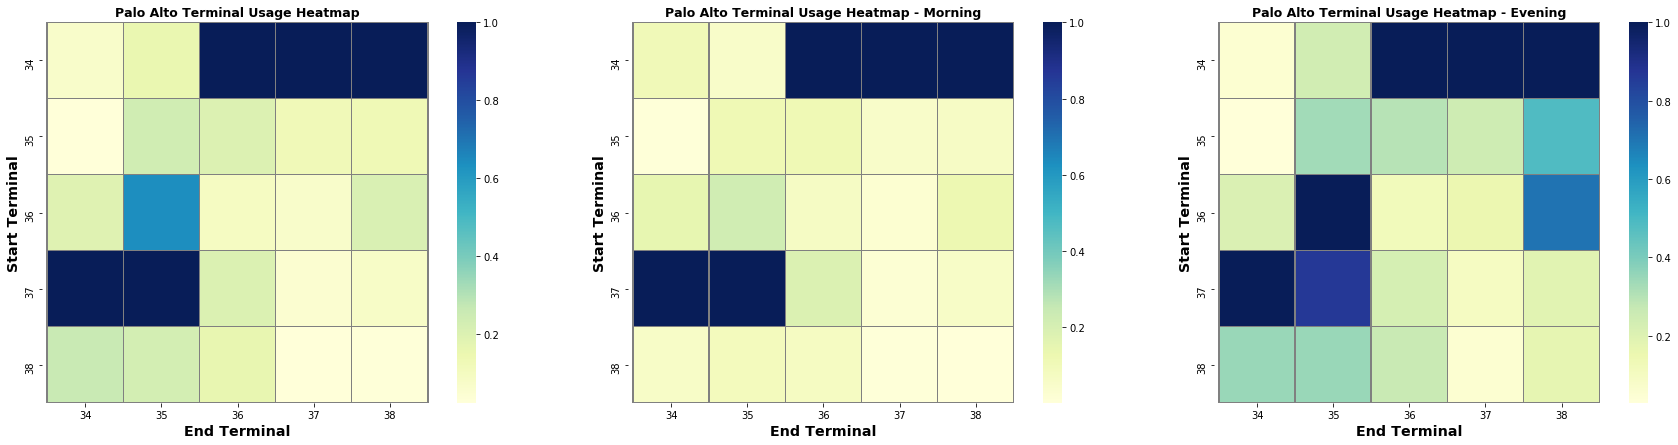

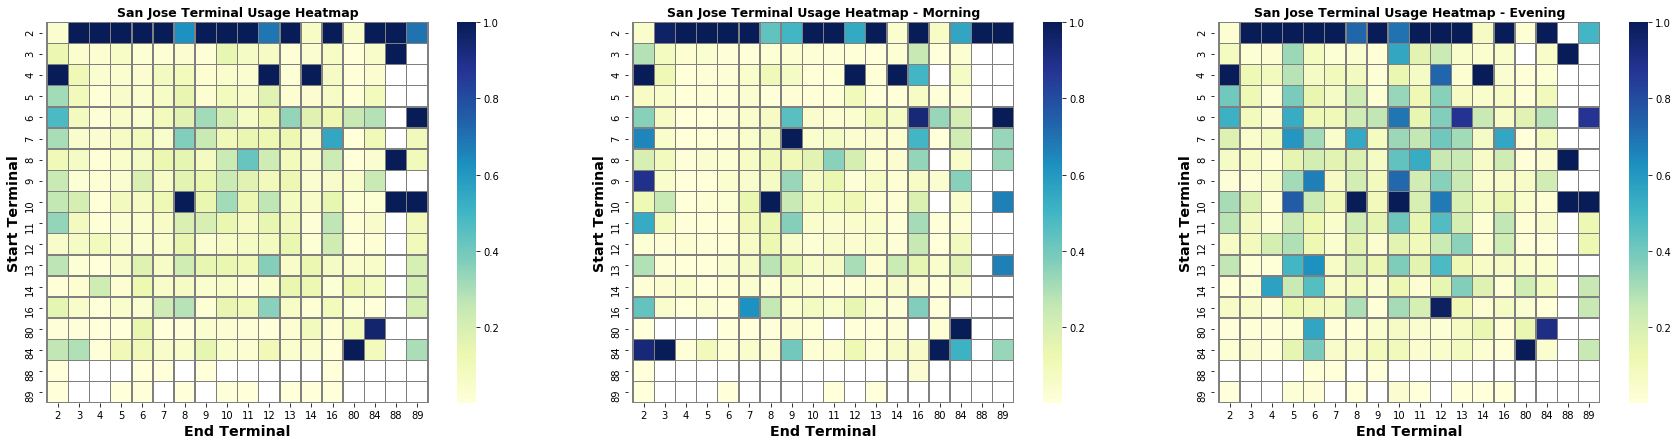

In [324]:
for z in sorted(pd.unique(regonalized_subscriber_terminal_usage.start_zip)):

    data = regonalized_subscriber_terminal_usage[regonalized_subscriber_terminal_usage.start_zip == z]
    data_am = data[data.start_date.dt.hour < 12]
    data_pm = data[data.start_date.dt.hour >= 12]
    
    grid = data.groupby(['start_terminal', 'end_terminal'])['bike_id'].count().unstack()
    grid_am = data_am.groupby(['start_terminal', 'end_terminal'])['bike_id'].count().unstack()
    grid_pm = data_pm.groupby(['start_terminal', 'end_terminal'])['bike_id'].count().unstack()

    # normalize the grid, easier to see differences
    norm_grid = grid/grid.max()
    norm_grid_am = grid_am/grid_am.max()
    norm_grid_pm = grid_pm/grid_pm.max()
    
    plot_size=7
    
    grid_max = grid_am.max().max()
    
    if grid_pm.max().max() > grid_max:
        grid_max = grid_pm.max().max()
    
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, sharey=True, figsize=(4.25*plot_size,plot_size))
    
    sns.heatmap(norm_grid, ax=ax0, linewidths=.5, square=True, cbar=True, cmap="YlGnBu", linecolor='gray')#, vmin=0, vmax=grid_max)
    title_all = '%s Terminal Usage Heatmap' % zip_lookup[z]
    ax0.set_title(title_all, size=TITLE_FONT_SIZE*0.5, weight='bold')
    ax0.set_xlabel('End Terminal', size=LABEL_FONT_SIZE*0.95, weight='bold')
    ax0.set_ylabel('Start Terminal', size=LABEL_FONT_SIZE*0.95, weight='bold')
    
    sns.heatmap(norm_grid_am, ax=ax1, linewidths=.5, square=True, cbar=True, cmap="YlGnBu", linecolor='gray')#, vmin=0, vmax=grid_max)
    title_am = '%s Terminal Usage Heatmap - Morning' % zip_lookup[z]
    ax1.set_title(title_am, size=TITLE_FONT_SIZE*0.5, weight='bold')
    ax1.set_xlabel('End Terminal', size=LABEL_FONT_SIZE*0.95, weight='bold')
    ax1.set_ylabel('Start Terminal', size=LABEL_FONT_SIZE*0.95, weight='bold')

    sns.heatmap(norm_grid_pm, ax=ax2, linewidths=.5, square=True, cbar=True, cmap="YlGnBu", linecolor='gray')#, vmin=0, vmax=grid_max)
    title_pm = '%s Terminal Usage Heatmap - Evening' % zip_lookup[z]
    ax2.set_title(title_pm, size=TITLE_FONT_SIZE*0.5, weight='bold')
    ax2.set_xlabel('End Terminal', size=LABEL_FONT_SIZE*0.95, weight='bold')
    ax2.set_ylabel('Start Terminal', size=LABEL_FONT_SIZE*0.95, weight='bold')

### Customer Terminal Usage

In [325]:
customer_terminal_usage = trip_data[trip_data.user_type == 'Customer'].copy()

# select only trips that start and end in same zip code
regonalized_customer_terminal_usage = customer_terminal_usage[customer_terminal_usage.start_zip == customer_terminal_usage.end_zip].copy()
non_regonalized_customer_terminal_usage = customer_terminal_usage[customer_terminal_usage.start_zip != customer_terminal_usage.end_zip].copy()

print('regonalized_customer_terminal_usage\t\t', len(regonalized_customer_terminal_usage))
print('non_regonalized_customer_terminal_usage\t\t', len(non_regonalized_customer_terminal_usage))

regonalized_customer_terminal_usage		 110524
non_regonalized_customer_terminal_usage		 463


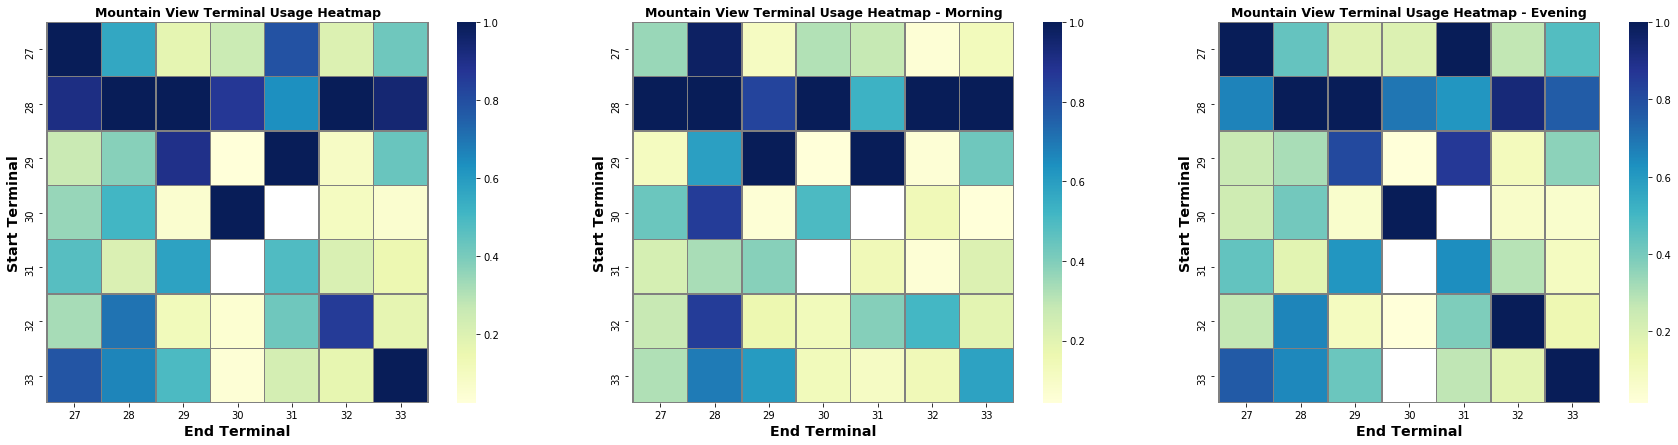

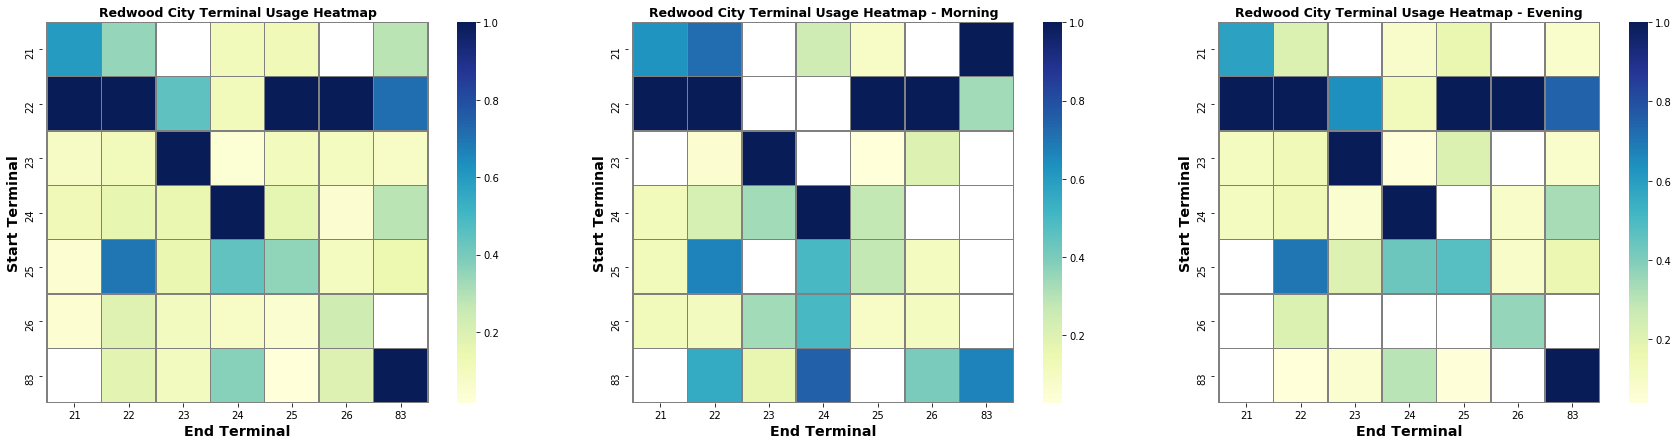

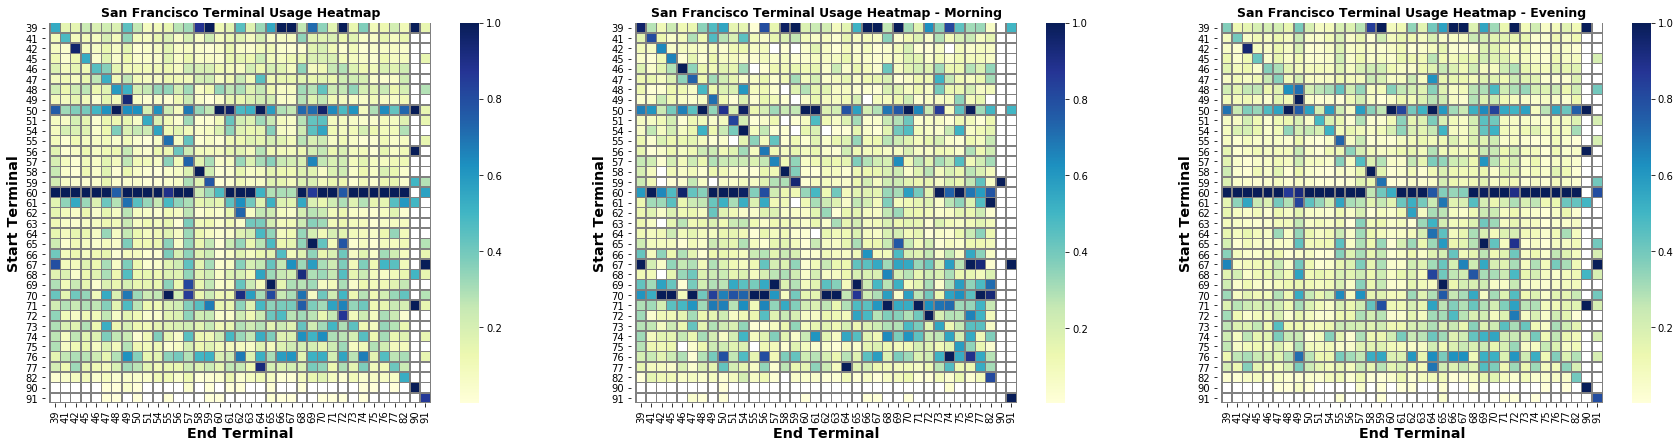

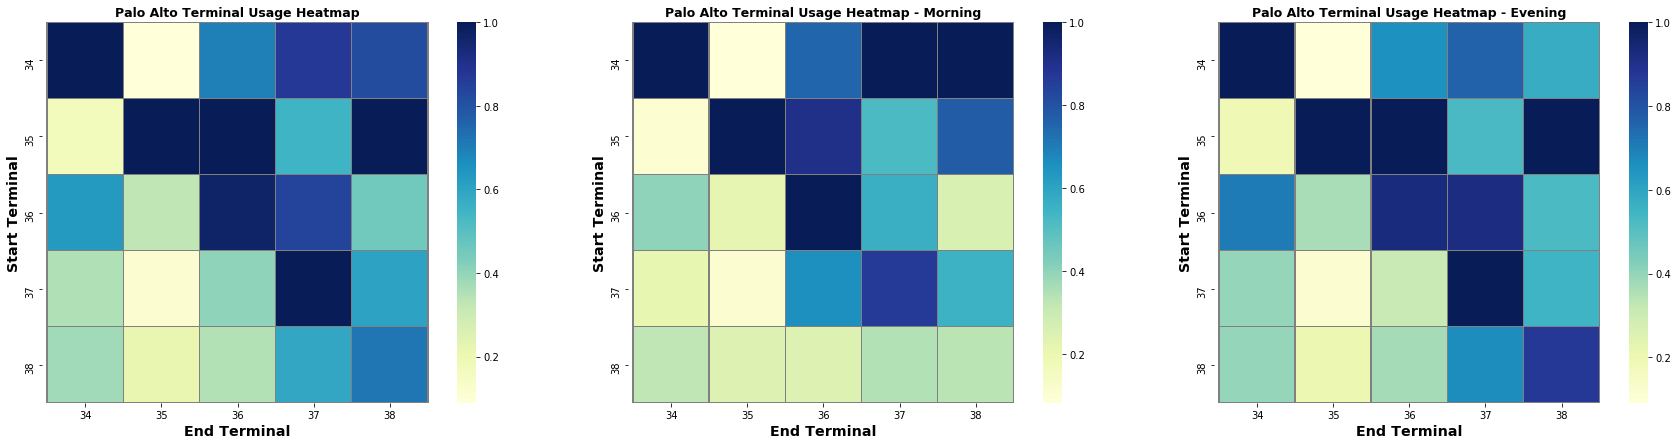

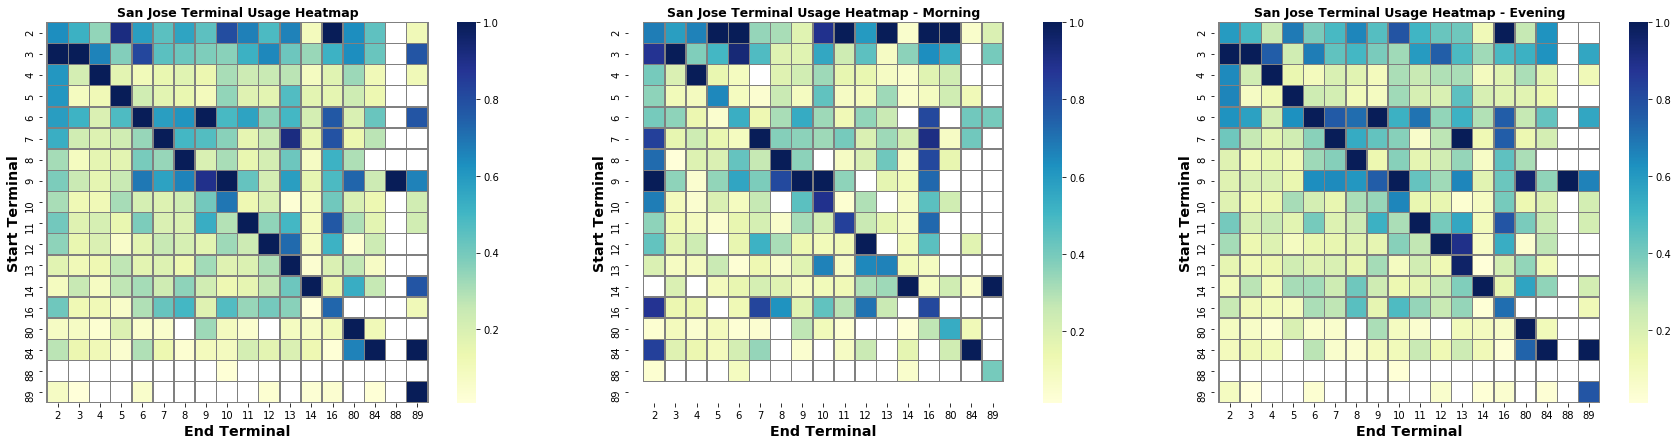

In [326]:
for z in sorted(pd.unique(regonalized_customer_terminal_usage.start_zip)):

    data = regonalized_customer_terminal_usage[regonalized_customer_terminal_usage.start_zip == z]
    data_am = data[data.start_date.dt.hour < 12]
    data_pm = data[data.start_date.dt.hour >= 12]
    
    grid = data.groupby(['start_terminal', 'end_terminal'])['bike_id'].count().unstack()
    grid_am = data_am.groupby(['start_terminal', 'end_terminal'])['bike_id'].count().unstack()
    grid_pm = data_pm.groupby(['start_terminal', 'end_terminal'])['bike_id'].count().unstack()

    # normalize the grid, easier to see differences
    norm_grid = grid/grid.max()
    norm_grid_am = grid_am/grid_am.max()
    norm_grid_pm = grid_pm/grid_pm.max()
    
    plot_size=7
    
    grid_max = grid_am.max().max()
    
    if grid_pm.max().max() > grid_max:
        grid_max = grid_pm.max().max()
    
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, sharey=True, figsize=(4.25*plot_size,plot_size))
    
    sns.heatmap(norm_grid, ax=ax0, linewidths=.5, square=True, cbar=True, cmap="YlGnBu", linecolor='gray')#, vmin=0, vmax=grid_max)
    title_all = '%s Terminal Usage Heatmap' % zip_lookup[z]
    ax0.set_title(title_all, size=TITLE_FONT_SIZE*0.5, weight='bold')
    ax0.set_xlabel('End Terminal', size=LABEL_FONT_SIZE*0.95, weight='bold')
    ax0.set_ylabel('Start Terminal', size=LABEL_FONT_SIZE*0.95, weight='bold')
    
    sns.heatmap(norm_grid_am, ax=ax1, linewidths=.5, square=True, cbar=True, cmap="YlGnBu", linecolor='gray')#, vmin=0, vmax=grid_max)
    title_am = '%s Terminal Usage Heatmap - Morning' % zip_lookup[z]
    ax1.set_title(title_am, size=TITLE_FONT_SIZE*0.5, weight='bold')
    ax1.set_xlabel('End Terminal', size=LABEL_FONT_SIZE*0.95, weight='bold')
    ax1.set_ylabel('Start Terminal', size=LABEL_FONT_SIZE*0.95, weight='bold')

    sns.heatmap(norm_grid_pm, ax=ax2, linewidths=.5, square=True, cbar=True, cmap="YlGnBu", linecolor='gray')#, vmin=0, vmax=grid_max)
    title_pm = '%s Terminal Usage Heatmap - Evening' % zip_lookup[z]
    ax2.set_title(title_pm, size=TITLE_FONT_SIZE*0.5, weight='bold')
    ax2.set_xlabel('End Terminal', size=LABEL_FONT_SIZE*0.95, weight='bold')
    ax2.set_ylabel('Start Terminal', size=LABEL_FONT_SIZE*0.95, weight='bold')
    
    plt.show()

# Goal 4 - Does weather affect Subscribers?

> The Weather in the Bay Area is quite temperate, but does the weather have an affect on ridership in different conditions?
- Subscribers
    - Rainy vs Non Rainy
    - Hot Temperatures
    - Cold Temperatures
- Commuters
    - Rainy vs Non Rainy
    - Hot Temperatures
    - Cold Temperatures

# Goal 3 - Growth in User Groups

> Clear patterns are present, but is the program growing?
- Subscriber Trips Per Day Growth <b>(0.126)</b> Overall
- Customer Trips Per Day Growth   <b>(-0.068)</b> Overall

#### Note on Color Coding
- Weekday Data points are yellow
- Weekend Data points are cyan
- Positive growth trend is green
- Negative Growth trend is red

In [14]:
subscriber_growth = subscriber_trips.copy()
subscriber_growth.reset_index(inplace=True)
subscriber_growth.set_index('start_date', inplace=True)

customer_growth = customer_trips.copy()
customer_growth.reset_index(inplace=True)
customer_growth.set_index('start_date', inplace=True)


growth = pd.DataFrame()
growth['subs'] = subscriber_growth.groupby(subscriber_growth.index.date)['bike_id'].count()
growth['subs_cumm'] = subscriber_growth.groupby(subscriber_growth.index.date)['bike_id'].count().cumsum()
growth['cust'] = customer_growth.groupby(customer_growth.index.date)['bike_id'].count()
growth['cust_cumm'] = customer_growth.groupby(customer_growth.index.date)['bike_id'].count().cumsum()
growth['day_count'] = range(1, len(growth) + 1 ,1)
growth.index = pd.to_datetime(growth.index)

def colorLookUp(x):
    if x < 4:
        return 'y'
    if x == 4:
        return 'r'
    else:
        return 'c'

growth['day_color'] = growth.index.dayofweek
growth['day_color'] = growth['day_color'].apply(lambda x: colorLookUp(x))

In [15]:
def plotGrowth(df, userType, title, x_lab='Program Operation Days', y_lab='Total Trips in a Day'):
    x = df['day_count']
    y = df[userType]

    if userType == 'subs_cumm':
        color = 'b'
    elif userType == 'cust_cumm':
        color = 'r'
    else:
        color = df['day_color']
    
    fig, ax = plt.subplots(figsize=(15,6))
    fit = scipy.stats.linregress(x, y)
    if fit.slope > 0.0:
        ax.plot(x, fit[0] * x + fit[1], color='green')
    else:
        ax.plot(x, fit[0] * x + fit[1], color='red')
    ax.scatter(x, y, alpha=0.5, c=color)
    line = '%sx + %s' % (fit.slope, fit.intercept)
    ax.set_title(title)
    ax.set_ylabel(y_lab)
    ax.set_xlabel(x_lab)
    ax.legend([line], loc=1)

    plt.show()
    
    return fit

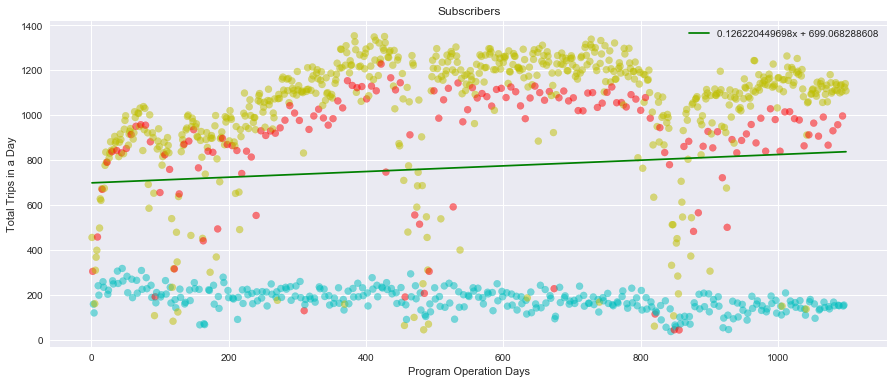

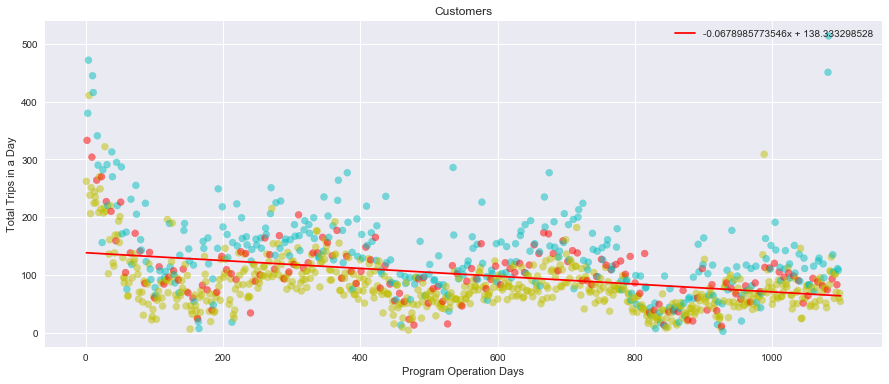

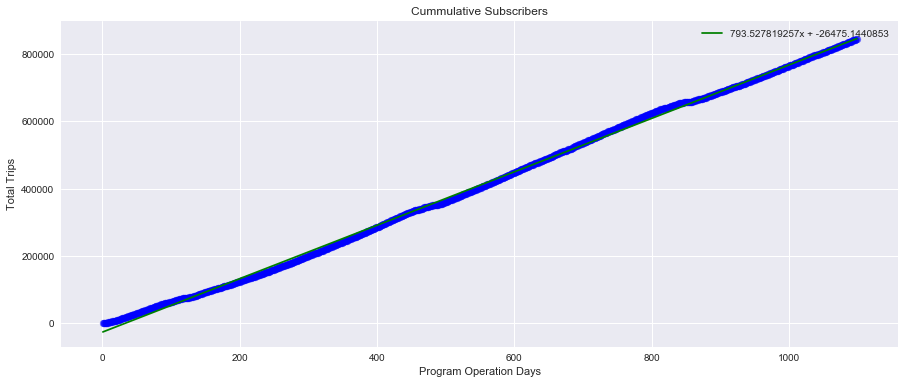

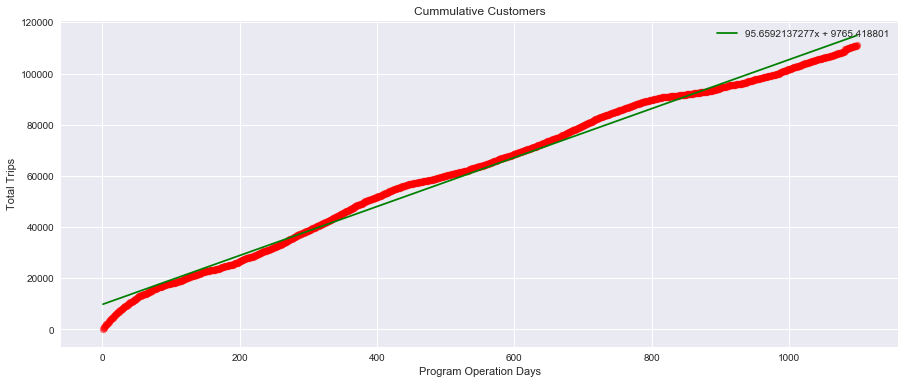

- Subscriber Trips Per Day Growth <b>(0.126)</b> Overall
- Customer Trips Per Day Growth   <b>(-0.068)</b> Overall


In [16]:
subscriber_growth_rate = plotGrowth(growth, userType='subs', title='Subscribers')
customer_growth_rate   = plotGrowth(growth, userType='cust', title='Customers')
cumm_subscriber_growth_rate = plotGrowth(growth, userType='subs_cumm', title='Cummulative Subscribers', y_lab='Total Trips')
cumm_customer_growth_rate   = plotGrowth(growth, userType='cust_cumm', title='Cummulative Customers', y_lab='Total Trips')

print('- Subscriber Trips Per Day Growth <b>(%0.3f)</b> Overall' % subscriber_growth_rate.slope)
print('- Customer Trips Per Day Growth   <b>(%0.3f)</b> Overall' % customer_growth_rate.slope)

# Statistical Data Anlysis 1 - First Two Months

> In the first two months of the Bay Area Bike Share Program going live, there is a sharp drop in the number of Customer Trips, and a seemingly matching boost in the number of Subscriber Trips. 2013-10-27
>
> These could be accounted for by a numebr of possibilities
- Users may have wanted to try the progam before commiting to a Subscription
- The Subscription Tier may not have been available for the initial launch of the program
- Users may not have been aware of the Subscription tier


## Results Preview
- The drop in Customers <b>is statistically significant</b> so we can safely ignore the first 60 days when measuring program growth
- The boost in Subscribers <b>is statistically significant</b> so we can safely ignore the first 60 days when measuring program growth






### Hypothesis Test 1 - Customer Growth Rate in first 60 Days

> $H1$o : Growth Rate for Customers in first 60 Days = Growth Rate for Customers after first 60 Days
>
> $H1$a : Growth Rate for Customers in first 60 Days ≠ Growth Rate for Customers after first 60 Days

### Hypothesis Test 1 Results:
> From calculations we arrive at margin of error <b>+/-22.777</b> and the mean difference is <b>134.257</b>, we  reject $H1$o
>
> In Addition, a T Test is Conducted and with T Statistic <b>19.141</b> and P Value <b>1.081e-70</b>, we  reject $H1$o


    
### Hypothesis Test 2 - Subscriber Growth Rate in first 60 Days

> $H2$o : Growth Rate for Subscribers in first 60 Days = Growth Rate for Subscribers after first 60 Days
>
> $H2$a : Growth Rate for Subscribers in first 60 Days ≠ Growth Rate for Subscribers after first 60 Days


### Hypothesis Test 2 Results:
> From calculations we arrive at margin of error <b>+/-79.602</b> and the mean difference is <b>-183.208</b>, we  reject $H2$o
>
> In Addition, a T Test is Conducted and with T Statistic <b>-3.178</b> and P Value <b>0.0015</b>, we  reject $H2$o

In [17]:
def hypothesisTest(df, interval=60, userType='cust'):
    
    first_interval = df[df.day_count <= interval].copy()
    first_interval.reset_index(inplace=True, drop=True)
    
    second_interval = df[df.day_count > interval].copy()
    second_interval.day_count = range(1, len(second_interval.index) +1 ,1)
    second_interval.reset_index(inplace=True, drop=True)
    
    # get data
    first_interval_data = first_interval[userType]
    second_interval_data = second_interval[userType]

    # calculate Means
    first_interval_mean = first_interval_data.mean()
    second_interval_mean = second_interval_data.mean()
    diff_mean = first_interval_mean - second_interval_mean
    
    # Variance
    first_interval_var = first_interval_data.var()
    second_interval_var = second_interval_data.var()
    
    # Length
    first_interval_count = len(first_interval_data)
    second_interval_count = len(second_interval_data)
    
    # Standard Deviation
    std_error = math.sqrt(first_interval_var/first_interval_count + second_interval_var/second_interval_count)

    # Margin of Error
    margin = 1.96*std_error


    # calculate t statistic and p value with scipy
    t, p = stats.ttest_ind(first_interval_data, second_interval_data)
    
    print('first_interval_mean\t', first_interval_mean)
    print('second_interval_mean\t', second_interval_mean)
    print('diff_mean\t\t', diff_mean)
    print('Standard Error:\t\t', std_error)
    print('Margin of Error:\t', margin)
    print('t statistic:\t\t', t)
    print('p value:\t\t', p)
    
    
    result = [first_interval_mean, second_interval_mean, diff_mean, std_error, margin, t, p]
    
    df_tmp = growth[growth.day_count > interval].copy()
    df_result = plotGrowth(df_tmp, userType=userType, title='Second Interval (> %s Days)' % interval)

    return result



first_interval_mean	 227.916666667
second_interval_mean	 93.6592877767
diff_mean		 134.25737889
Standard Error:		 11.621084572783362
Margin of Error:	 22.777325762655387
t statistic:		 19.1414230558
p value:		 1.08127233956e-70


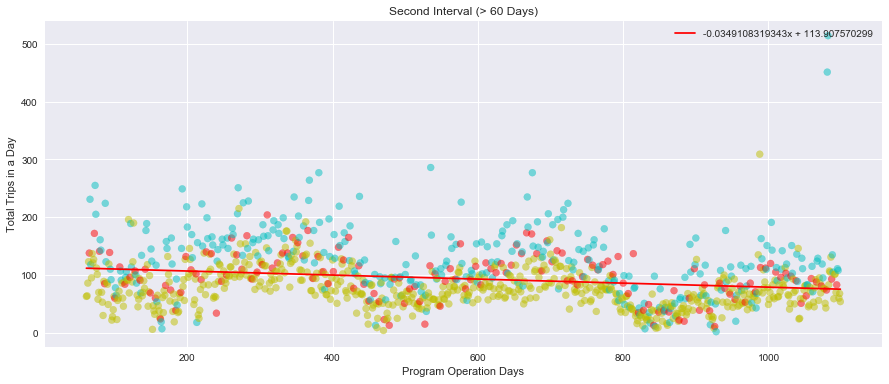

In [18]:
customer_hypothesis = hypothesisTest(growth, interval=60, userType='cust')

first_interval_mean	 595.283333333
second_interval_mean	 778.491819057
diff_mean		 -183.208485723
Standard Error:		 40.61320316294578
Margin of Error:	 79.60187819937373
t statistic:		 -3.17772096292
p value:		 0.00152584553839


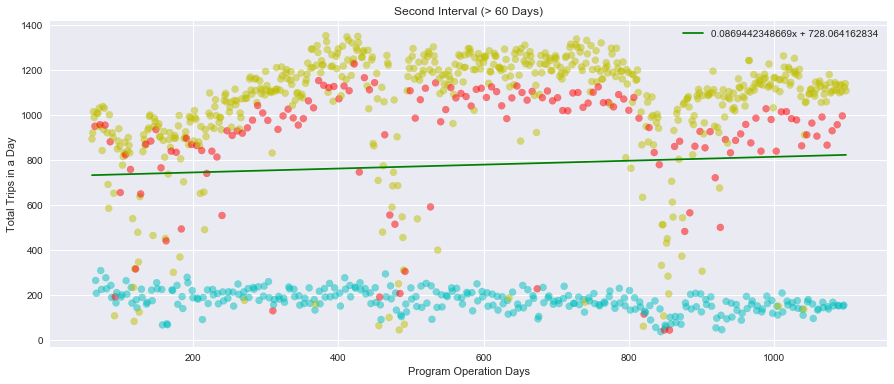

In [19]:
subscriber_hypothesis = hypothesisTest(growth, interval=60, userType='subs')

In [20]:
# we can safely ignore teh first 60 days of growth data, lets prune it out
growth_pruned = growth[growth.day_count > 60].copy()
growth_pruned.head(10)

,subs,subs_cumm,cust,cust_cumm,day_count,day_color
2013-10-28,894,36611,63,13738,61,y
2013-10-29,922,37533,64,13802,62,y
2013-10-30,1016,38549,86,13888,63,y
2013-10-31,990,39539,123,14011,64,y
2013-11-01,951,40490,138,14149,65,r
2013-11-02,265,40755,231,14380,66,c
2013-11-03,208,40963,118,14498,67,c
2013-11-04,1010,41973,95,14593,68,y
2013-11-05,1008,42981,137,14730,69,y
2013-11-06,950,43931,121,14851,70,y


## Subscriber Usage is Growing, Mostly

> Subscrber Rides Are Growing on Weekdays, But Shrinking on Weekends
>
- Subscriber Trips Per Day Growth <b>(0.087)</b> Overall
- Subscriber Trips Per Day Growth <b>(0.155)</b> Weekday
- Subscriber Trips Per Day Growth <b>(-0.076)</b> Weekend
- Subscriber Trips Per Day Growth <b>(0.155)</b> Weekday (exc. Friday)
- Subscriber Trips Per Day Growth <b>(-0.026)</b> Weekend (inc. Friday)

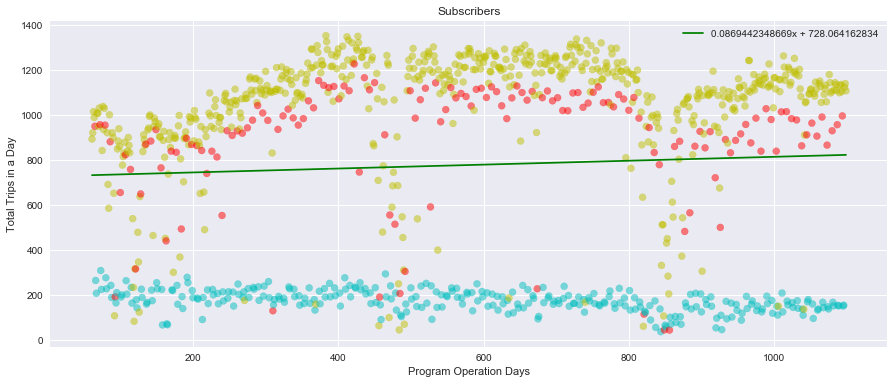

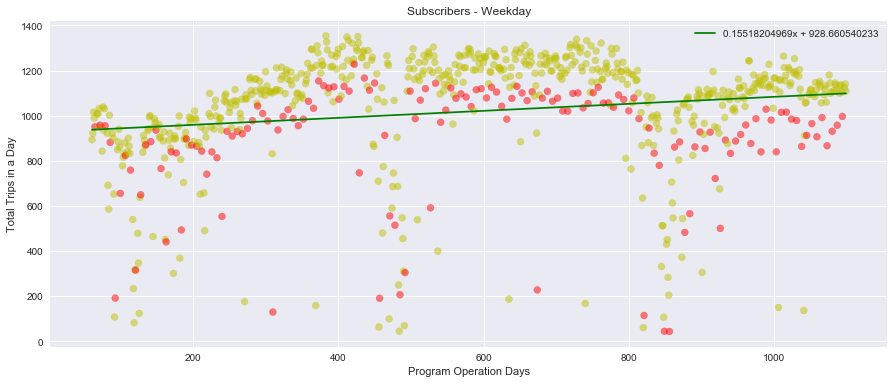

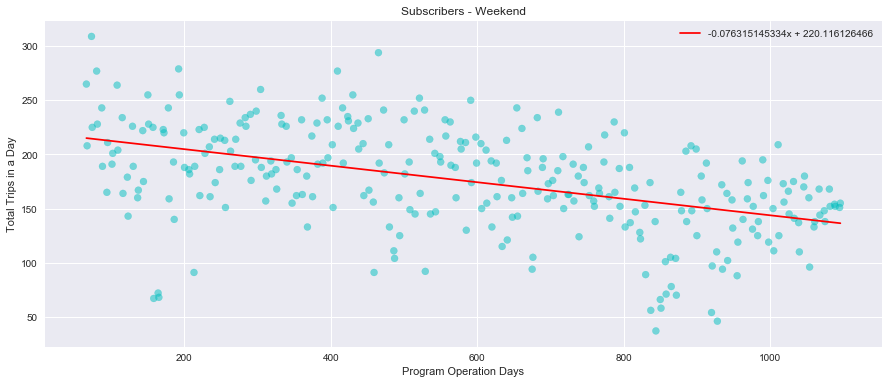

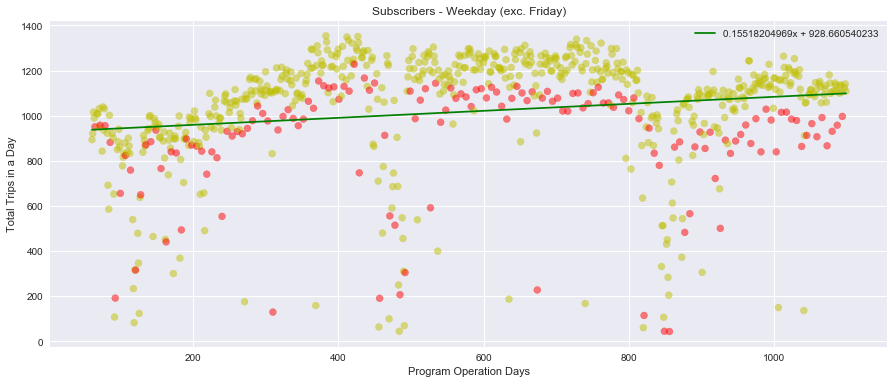

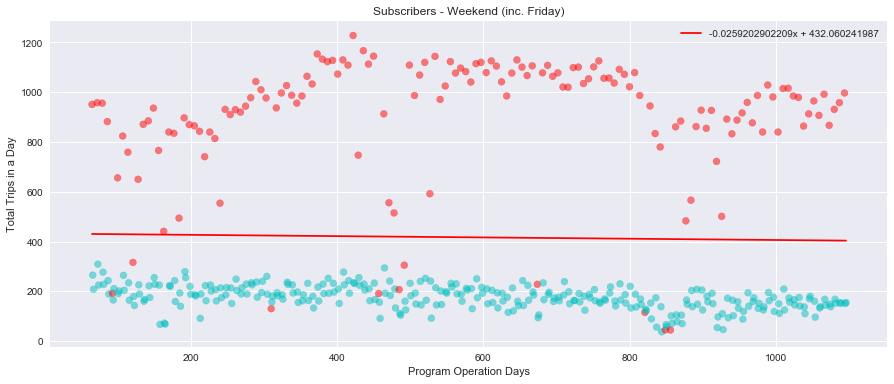

- Subscriber Trips Per Day Growth <b>(0.087)</b> Overall
- Subscriber Trips Per Day Growth <b>(0.155)</b> Weekday
- Subscriber Trips Per Day Growth <b>(-0.076)</b> Weekend
- Subscriber Trips Per Day Growth <b>(0.155)</b> Weekday (exc. Friday)
- Subscriber Trips Per Day Growth <b>(-0.026)</b> Weekend (inc. Friday)


In [21]:

subscriber_growth_rate = plotGrowth(growth_pruned, userType='subs', title='Subscribers')

subscriber_growth_weekday = growth_pruned[growth_pruned.index.dayofweek < 5].copy()
subscriber_growth_weekday_rate = plotGrowth(subscriber_growth_weekday, userType='subs', title='Subscribers - Weekday')

subscriber_growth_weekend = growth_pruned[growth_pruned.index.dayofweek >= 5].copy()
subscriber_growth_weekend_rate_noF = plotGrowth(subscriber_growth_weekend, userType='subs', title='Subscribers - Weekend')

subscriber_growth_weekday = growth_pruned[growth_pruned.index.dayofweek < 5].copy()
subscriber_growth_weekday_rate_noF = plotGrowth(subscriber_growth_weekday, userType='subs', title='Subscribers - Weekday (exc. Friday)')

subscriber_growth_weekend = growth_pruned[growth_pruned.index.dayofweek >= 4].copy()
subscriber_growth_weekend_rate = plotGrowth(subscriber_growth_weekend, userType='subs', title='Subscribers - Weekend (inc. Friday)')

print('- Subscriber Trips Per Day Growth <b>(%0.3f)</b> Overall' % subscriber_growth_rate.slope)
print('- Subscriber Trips Per Day Growth <b>(%0.3f)</b> Weekday' % subscriber_growth_weekday_rate.slope)
print('- Subscriber Trips Per Day Growth <b>(%0.3f)</b> Weekend' % subscriber_growth_weekend_rate_noF.slope)
print('- Subscriber Trips Per Day Growth <b>(%0.3f)</b> Weekday (exc. Friday)' % subscriber_growth_weekday_rate_noF.slope)
print('- Subscriber Trips Per Day Growth <b>(%0.3f)</b> Weekend (inc. Friday)' % subscriber_growth_weekend_rate.slope)

# Customer Usage is Shrinking, but not by much

> Customer Rides are shrinking all across the board 
>
- Customer Trips Per Day Growth <b>(-0.035)</b> Overall
- Customer Trips Per Day Growth <b>(-0.029)</b> Weekday
- Customer Trips Per Day Growth <b>(-0.050)</b> Weekend
- Customer Trips Per Day Growth <b>(-0.029)</b> Weekday (exc. Friday)
- Customer Trips Per Day Growth <b>(-0.045)</b> Weekend (inc. Friday)

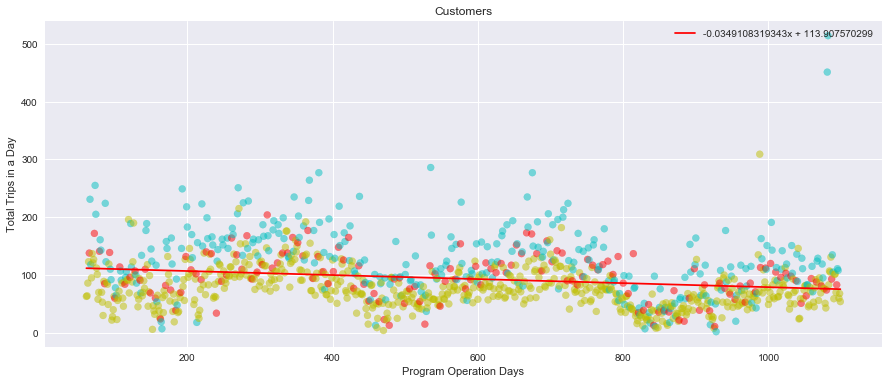

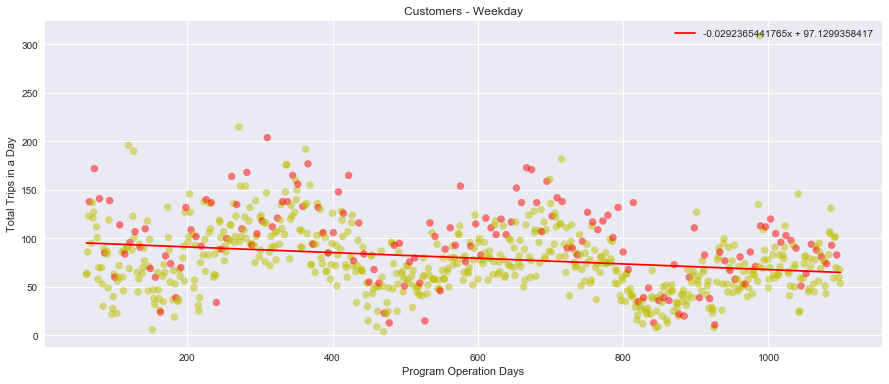

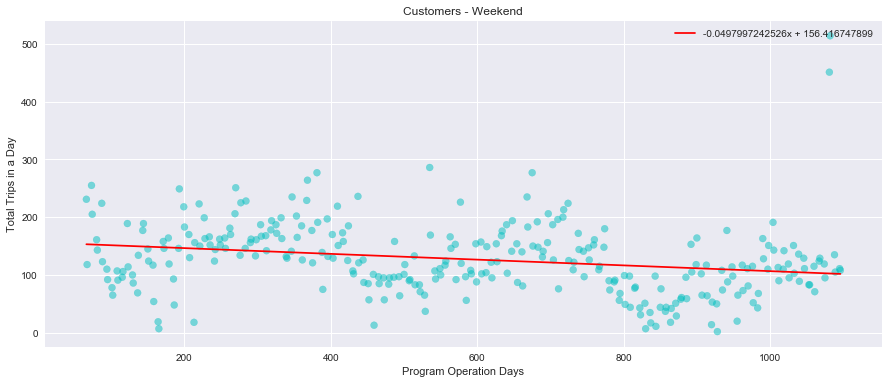

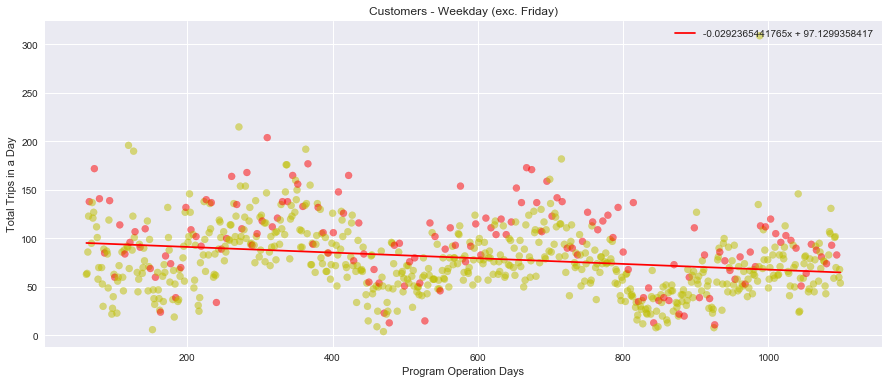

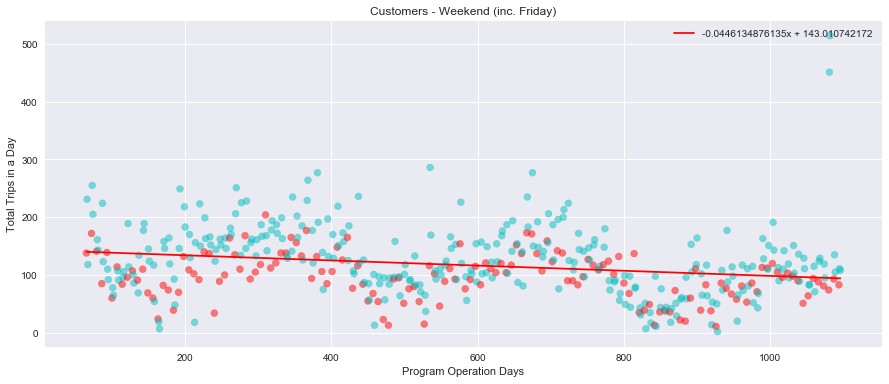

- Customer Trips Per Day Growth <b>(-0.035)</b> Overall
- Customer Trips Per Day Growth <b>(-0.029)</b> Weekday
- Customer Trips Per Day Growth <b>(-0.050)</b> Weekend
- Customer Trips Per Day Growth <b>(-0.029)</b> Weekday (exc. Friday)
- Customer Trips Per Day Growth <b>(-0.045)</b> Weekend (inc. Friday)


In [22]:

customer_growth_rate = plotGrowth(growth_pruned, userType='cust', title='Customers')

customer_growth_weekday = growth_pruned[growth_pruned.index.dayofweek < 5].copy()
customer_growth_weekday_rate = plotGrowth(customer_growth_weekday, userType='cust', title='Customers - Weekday')

customer_growth_weekend = growth_pruned[growth_pruned.index.dayofweek >= 5].copy()
customer_growth_weekend_rate_noF = plotGrowth(customer_growth_weekend, userType='cust', title='Customers - Weekend')

customer_growth_weekday = growth_pruned[growth_pruned.index.dayofweek < 5].copy()
customer_growth_weekday_rate_noF = plotGrowth(customer_growth_weekday, userType='cust', title='Customers - Weekday (exc. Friday)')

customer_growth_weekend = growth_pruned[growth_pruned.index.dayofweek >= 4].copy()
customer_growth_weekend_rate = plotGrowth(customer_growth_weekend, userType='cust', title='Customers - Weekend (inc. Friday)')

print('- Customer Trips Per Day Growth <b>(%0.3f)</b> Overall' % customer_growth_rate.slope)
print('- Customer Trips Per Day Growth <b>(%0.3f)</b> Weekday' % customer_growth_weekday_rate.slope)
print('- Customer Trips Per Day Growth <b>(%0.3f)</b> Weekend' % customer_growth_weekend_rate_noF.slope)
print('- Customer Trips Per Day Growth <b>(%0.3f)</b> Weekday (exc. Friday)' % customer_growth_weekday_rate_noF.slope)
print('- Customer Trips Per Day Growth <b>(%0.3f)</b> Weekend (inc. Friday)' % customer_growth_weekend_rate.slope)

# Subscriber Daily Usage Trends
- Subscriber Trips Per Day Growth <b>(0.125)</b> on Monday
- Subscriber Trips Per Day Growth <b>(0.190)</b> on Tueday
- Subscriber Trips Per Day Growth <b>(0.206)</b> on Wednesday
- Subscriber Trips Per Day Growth <b>(0.170)</b> on Thursday
- Subscriber Trips Per Day Growth <b>(0.083)</b> on Friday
- Subscriber Trips Per Day Growth <b>(-0.080)</b> on Saturday
- Subscriber Trips Per Day Growth <b>(-0.072)</b> on Sunday

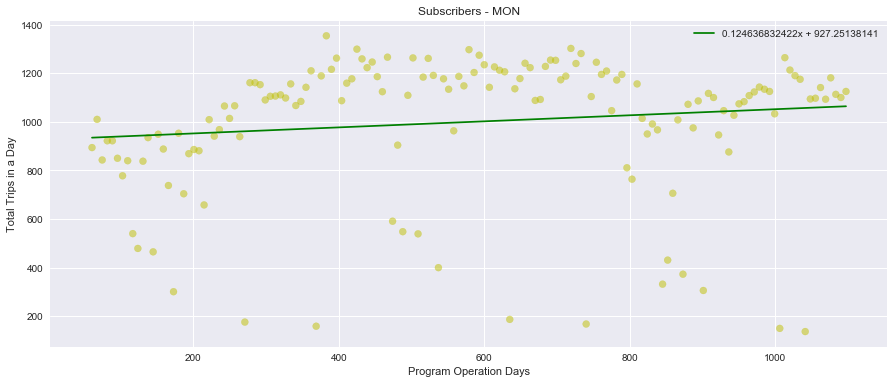

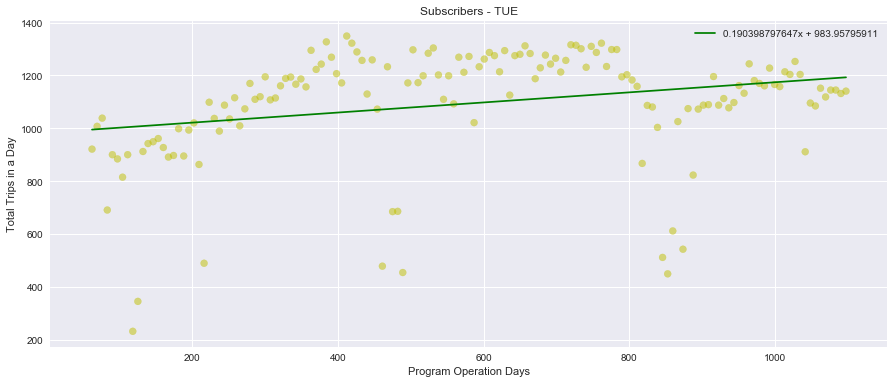

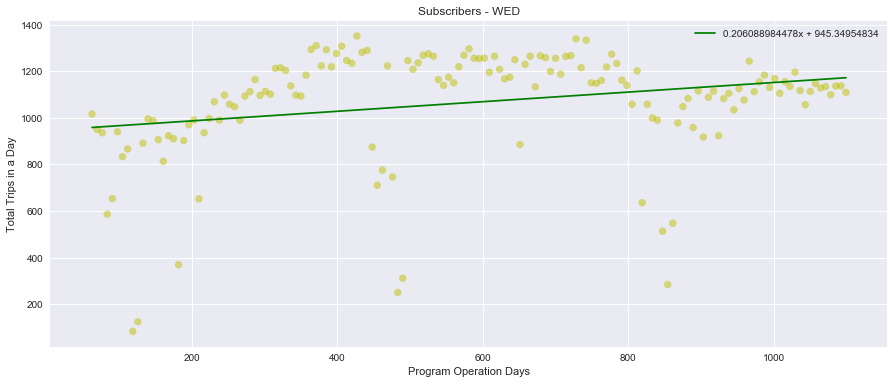

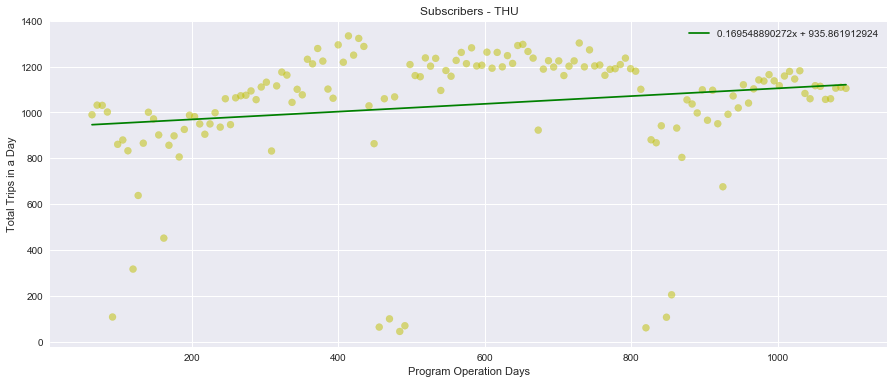

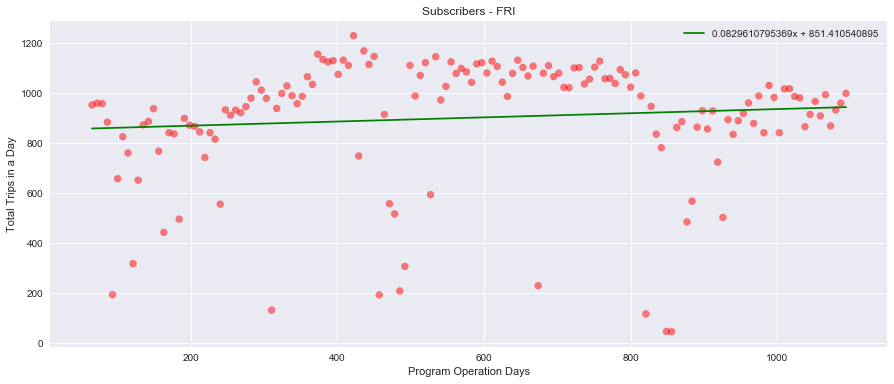

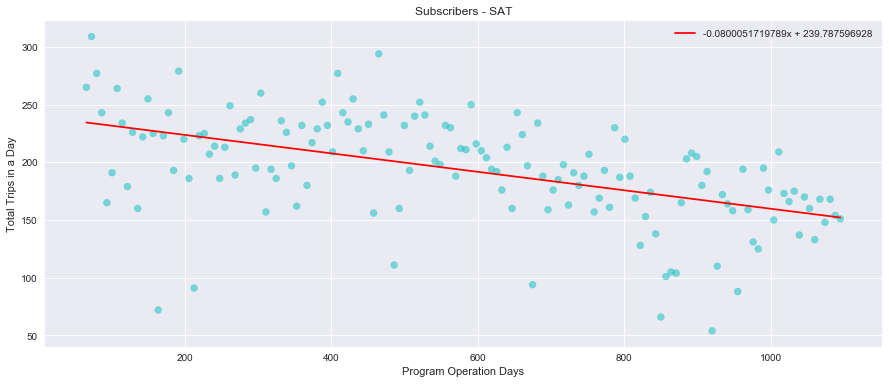

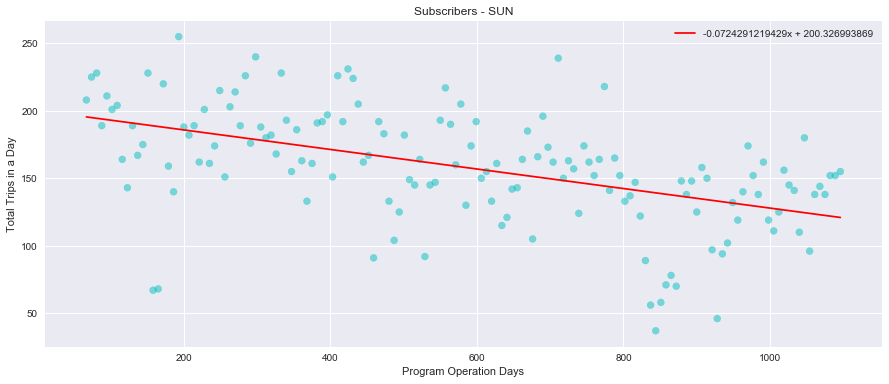

- Subscriber Trips Per Day Growth <b>(0.125)</b> on Monday
- Subscriber Trips Per Day Growth <b>(0.190)</b> on Tuesday
- Subscriber Trips Per Day Growth <b>(0.206)</b> on Wednesday
- Subscriber Trips Per Day Growth <b>(0.170)</b> on Thursday
- Subscriber Trips Per Day Growth <b>(0.083)</b> on Friday
- Subscriber Trips Per Day Growth <b>(-0.080)</b> on Saturday
- Subscriber Trips Per Day Growth <b>(-0.072)</b> on Sunday


In [23]:
rates = {}
slopes = []
for i in range(0, len(day_labels)):
    temp = growth_pruned[growth_pruned.index.dayofweek == i].copy()
    temp_title = 'Subscribers - %s' % day_labels[i]
    temp_rate = plotGrowth(temp, userType='subs', title=temp_title)
    rates[day_labels[i]] = temp_rate.slope
    slopes.append(temp_rate.slope)

subscriber_growth_table = pd.Series(rates)

c = 0
for item in slopes:
    print('- Subscriber Trips Per Day Growth <b>(%0.3f)</b> on %s' % (float(item), day_labels_full[c].title()))
    c += 1


# Customer Daily Usage Trends
- Customer Trips Per Day Growth <b>(-0.030)</b> on Monday
- Customer Trips Per Day Growth <b>(-0.025)</b> on Tuesday
- Customer Trips Per Day Growth <b>(-0.033)</b> on Wednesday
- Customer Trips Per Day Growth <b>(-0.023)</b> on Thursday
- Customer Trips Per Day Growth <b>(-0.035)</b> on Friday
- Customer Trips Per Day Growth <b>(-0.048)</b> on Saturday
- Customer Trips Per Day Growth <b>(-0.051)</b> on Sunday

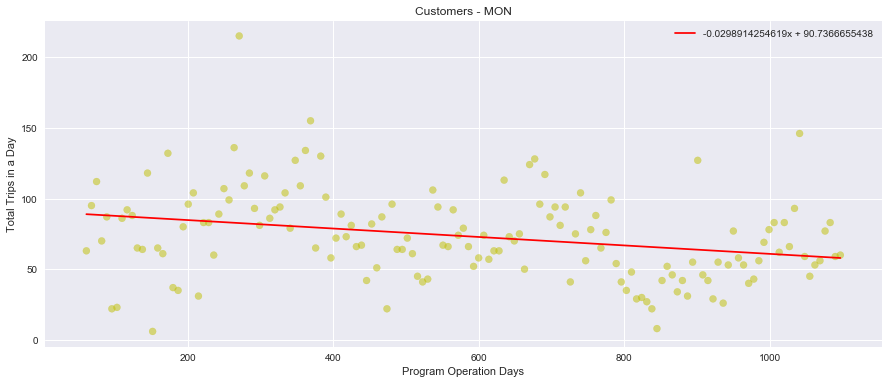

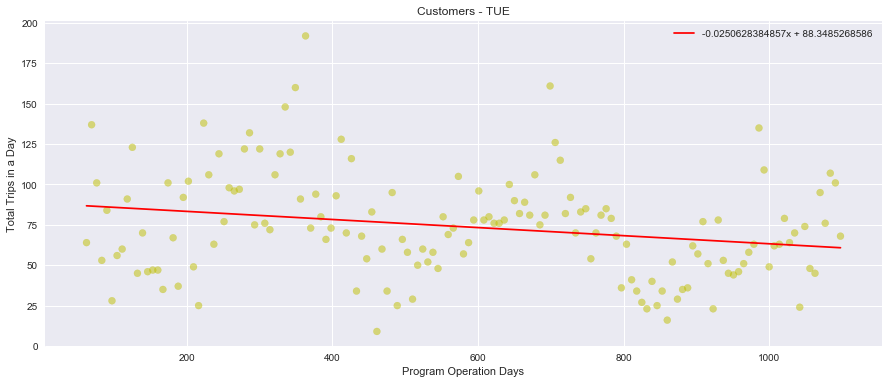

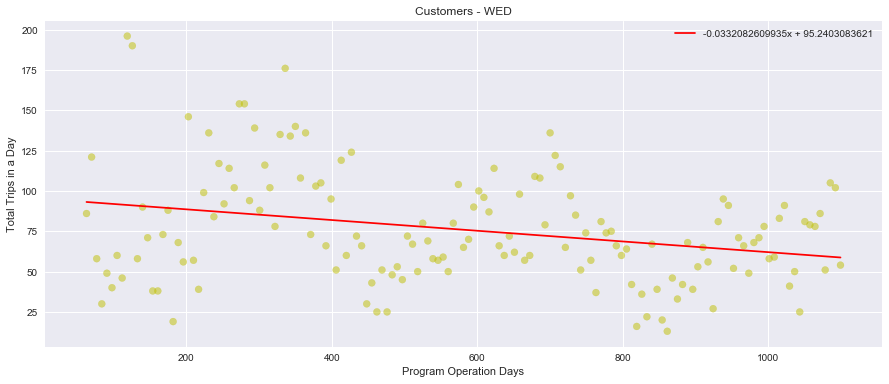

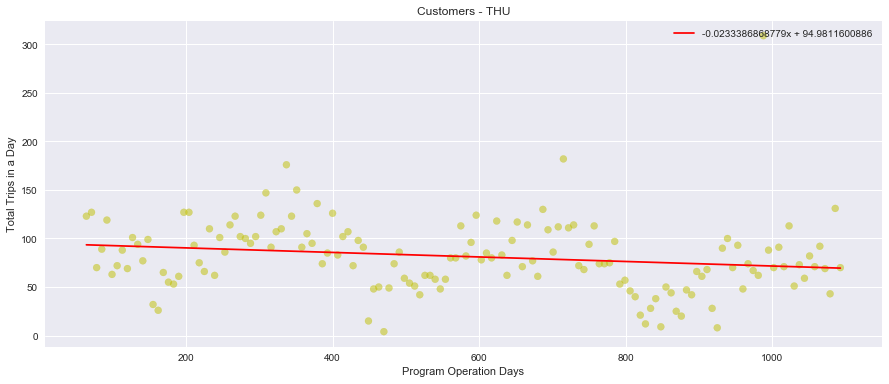

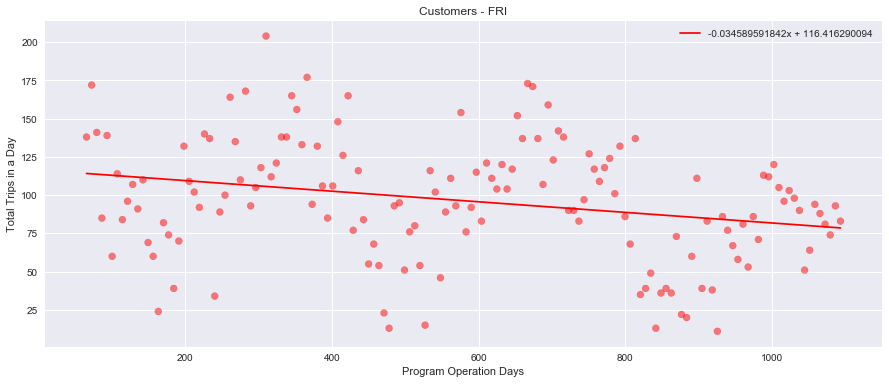

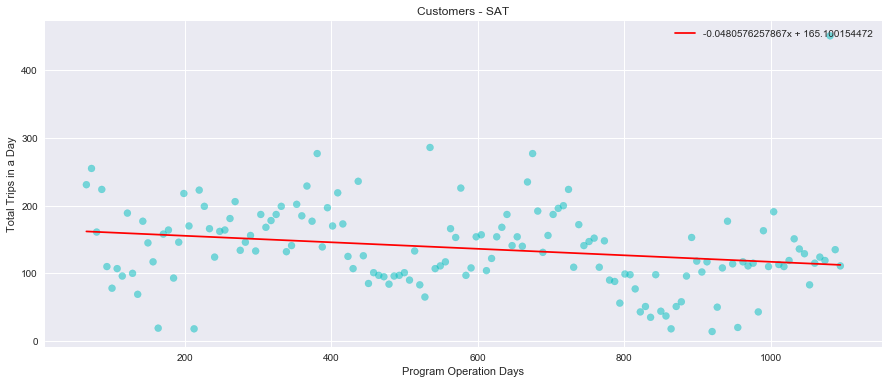

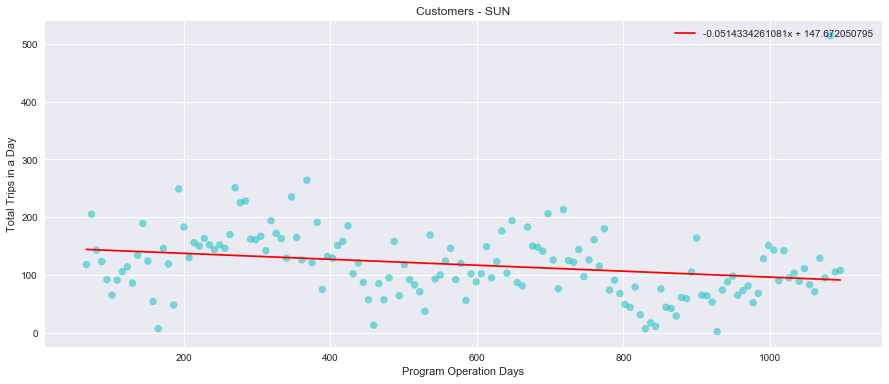

- Customer Trips Per Day Growth <b>(-0.030)</b> on Monday
- Customer Trips Per Day Growth <b>(-0.025)</b> on Tuesday
- Customer Trips Per Day Growth <b>(-0.033)</b> on Wednesday
- Customer Trips Per Day Growth <b>(-0.023)</b> on Thursday
- Customer Trips Per Day Growth <b>(-0.035)</b> on Friday
- Customer Trips Per Day Growth <b>(-0.048)</b> on Saturday
- Customer Trips Per Day Growth <b>(-0.051)</b> on Sunday


In [24]:
rates = {}
slopes = []
for i in range(0, len(day_labels)):
    temp = growth_pruned[growth_pruned.index.dayofweek == i].copy()
    temp_title = 'Customers - %s' % day_labels[i]
    temp_rate = plotGrowth(temp, userType='cust', title=temp_title)
    rates[day_labels[i]] = temp_rate.slope
    slopes.append(temp_rate.slope)

customer_growth_table = pd.Series(rates)

c = 0
for item in slopes:
    print('- Customer Trips Per Day Growth <b>(%0.3f)</b> on %s' % (float(item), day_labels_full[c].title()))
    c += 1



# Daily Usage Trends Quickview

> Customers
- Customer Trips Per Day Growth <b>(-0.030)</b> on Monday
- Customer Trips Per Day Growth <b>(-0.025)</b> on Tuesday
- Customer Trips Per Day Growth <b>(-0.033)</b> on Wednesday
- Customer Trips Per Day Growth <b>(-0.023)</b> on Thursday
- Customer Trips Per Day Growth <b>(-0.035)</b> on Friday
- Customer Trips Per Day Growth <b>(-0.048)</b> on Saturday
- Customer Trips Per Day Growth <b>(-0.051)</b> on Sunday
>
> Subscribers
- Subscriber Trips Per Day Growth <b>(0.125)</b> on Monday
- Subscriber Trips Per Day Growth <b>(0.190)</b> on Tueday
- Subscriber Trips Per Day Growth <b>(0.206)</b> on Wednesday
- Subscriber Trips Per Day Growth <b>(0.170)</b> on Thursday
- Subscriber Trips Per Day Growth <b>(0.083)</b> on Friday
- Subscriber Trips Per Day Growth <b>(-0.080)</b> on Saturday
- Subscriber Trips Per Day Growth <b>(-0.072)</b> on Sunday
>

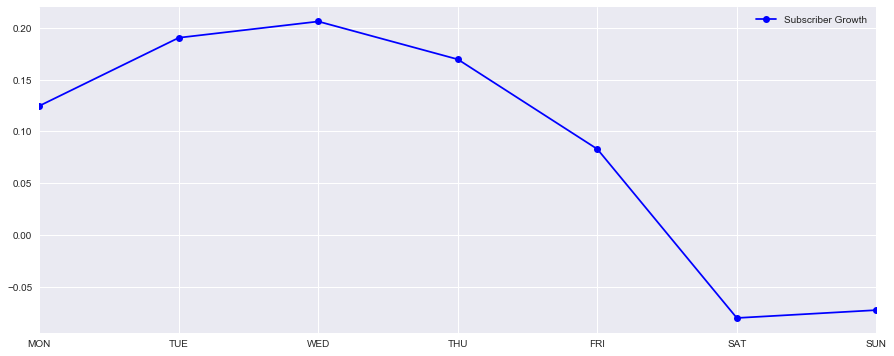

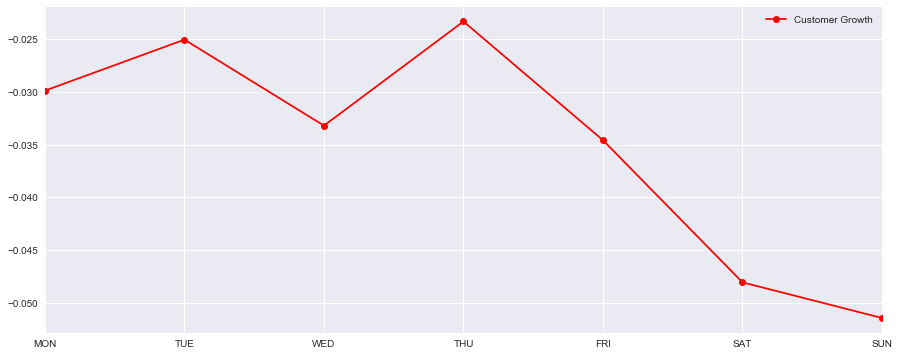

In [25]:
daily_growth_rates = pd.DataFrame()
daily_growth_rates['customer_growth'] = customer_growth_table
daily_growth_rates['subscriber_growth'] = subscriber_growth_table

daily_growth_rates['dummy'] = [4, 0, 5, 6, 3, 1, 2]
daily_growth_rates.sort_values('dummy', inplace=True)
daily_growth_rates.drop('dummy', axis=1, inplace=True)

ax = daily_growth_rates.subscriber_growth.plot(kind='line', color='b', marker='o', figsize=(15,6))
ax.set_xticklabels(['MON','TUE','WED','THU','FRI','SAT','SUN'])
ax.legend(['Subscriber Growth'], loc=1)
plt.show()


ax = daily_growth_rates.customer_growth.plot(kind='line', color='r', marker='o', figsize=(15,6))
ax.set_xticklabels(['MON','TUE','WED','THU','FRI','SAT','SUN'])
ax.legend(['Customer Growth'], loc=1)
plt.show()

In [26]:
daily_growth_rates.head(10)

,customer_growth,subscriber_growth
MON,-0.029891,0.124637
TUE,-0.025063,0.190399
WED,-0.033208,0.206089
THU,-0.023339,0.169549
FRI,-0.034590,0.082961
SAT,-0.048058,-0.080005
SUN,-0.051433,-0.072429


## Analyze Only Weekday Morning and Evening Commutes

>Previously, we deduced that the first 60 days of the program do not reflect customer and subscriber usage well
>
> we are going to prune out all recods prior to October 28th, 2013

In [27]:
prune_date = datetime.datetime.strptime('2013-10-28', '%Y-%m-%d')
am_commuter_trips = am_commuter_trips[am_commuter_trips.start_date > prune_date]
pm_commuter_trips = pm_commuter_trips[pm_commuter_trips.start_date > prune_date]

prune_subscriber_trips = subscriber_trips[subscriber_trips.start_date > prune_date]

prune_subscriber_weekend_trips = prune_subscriber_trips[prune_subscriber_trips.start_date.dt.day > 4]

prune_customer_trips = customer_trips[customer_trips.start_date > prune_date]

## Split into Weekday and Weekend Commuter Records

In [28]:
weekday_am_commuters = am_commuter_trips[am_commuter_trips.start_date.dt.dayofweek < 5]
weekend_am_commuters = am_commuter_trips[am_commuter_trips.start_date.dt.dayofweek >= 5]

In [29]:
weekday_pm_commuters = pm_commuter_trips[pm_commuter_trips.start_date.dt.dayofweek < 5]
weekend_pm_commuters = pm_commuter_trips[pm_commuter_trips.start_date.dt.dayofweek >= 5]

# Identifying Popular Stations

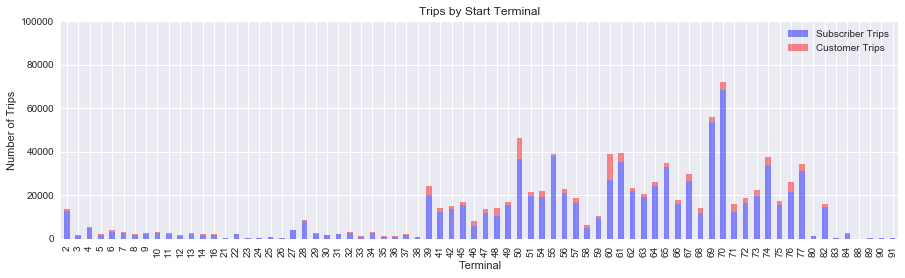

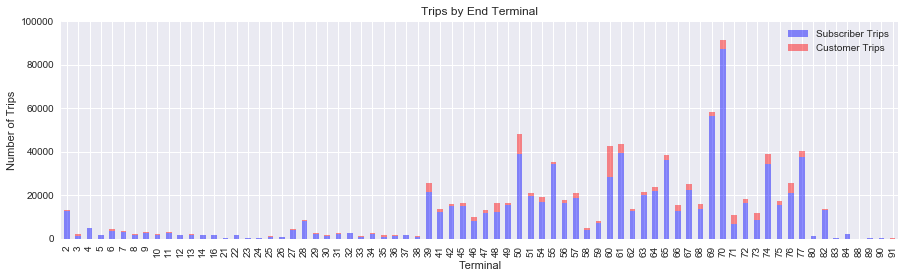

In [30]:
# user groups by Hour of the Day
all_trips = pd.DataFrame()
all_trips['subscriber_trips']= subscriber_trips.groupby('start_terminal')['bike_id'].count()
all_trips['customer_trips']= customer_trips.groupby('start_terminal')['bike_id'].count()

ax = all_trips[['subscriber_trips', 'customer_trips']].plot(kind='bar', stacked=True, color=['b', 'r'], alpha=0.45, figsize=(15,4))
ax.set_title('Trips by Start Terminal')
ax.set_xlabel('Terminal')
ax.set_ylabel('Number of Trips')
ax.set_ylim(0, 100000)
ax.legend(['Subscriber Trips', 'Customer Trips'])
plt.show()



# user groups by Hour of the Day
all_trips = pd.DataFrame()
all_trips['subscriber_trips']= subscriber_trips.groupby('end_terminal')['bike_id'].count()
all_trips['customer_trips']= customer_trips.groupby('end_terminal')['bike_id'].count()

ax = all_trips[['subscriber_trips', 'customer_trips']].plot(kind='bar', stacked=True, color=['b', 'r'], alpha=0.45, figsize=(15,4))
ax.set_title('Trips by End Terminal')
ax.set_xlabel('Terminal')
ax.set_ylabel('Number of Trips')
ax.set_ylim(0, 100000)
ax.legend(['Subscriber Trips', 'Customer Trips'])
plt.show()

# Popular stations for Subscribers - Weekdays

Morning Commuter Start Terminal Usage - Weekdays	 Int64Index([70, 69, 50, 55, 74, 61, 73, 77, 67, 54], dtype='int64', name='start_terminal')
Morning Commuter End Terminal Usage - Weekdays		 Int64Index([70, 65, 61, 77, 69, 55, 60, 63, 51, 74], dtype='int64', name='end_terminal')
Evening Commuter Start Terminal Usage - Weekdays	 Int64Index([70, 65, 61, 69, 77, 64, 60, 67, 55, 74], dtype='int64', name='start_terminal')
Evening Commuter End Terminal Usage - Weekdays		 Int64Index([70, 69, 50, 55, 74, 77, 61, 65, 39, 60], dtype='int64', name='end_terminal')


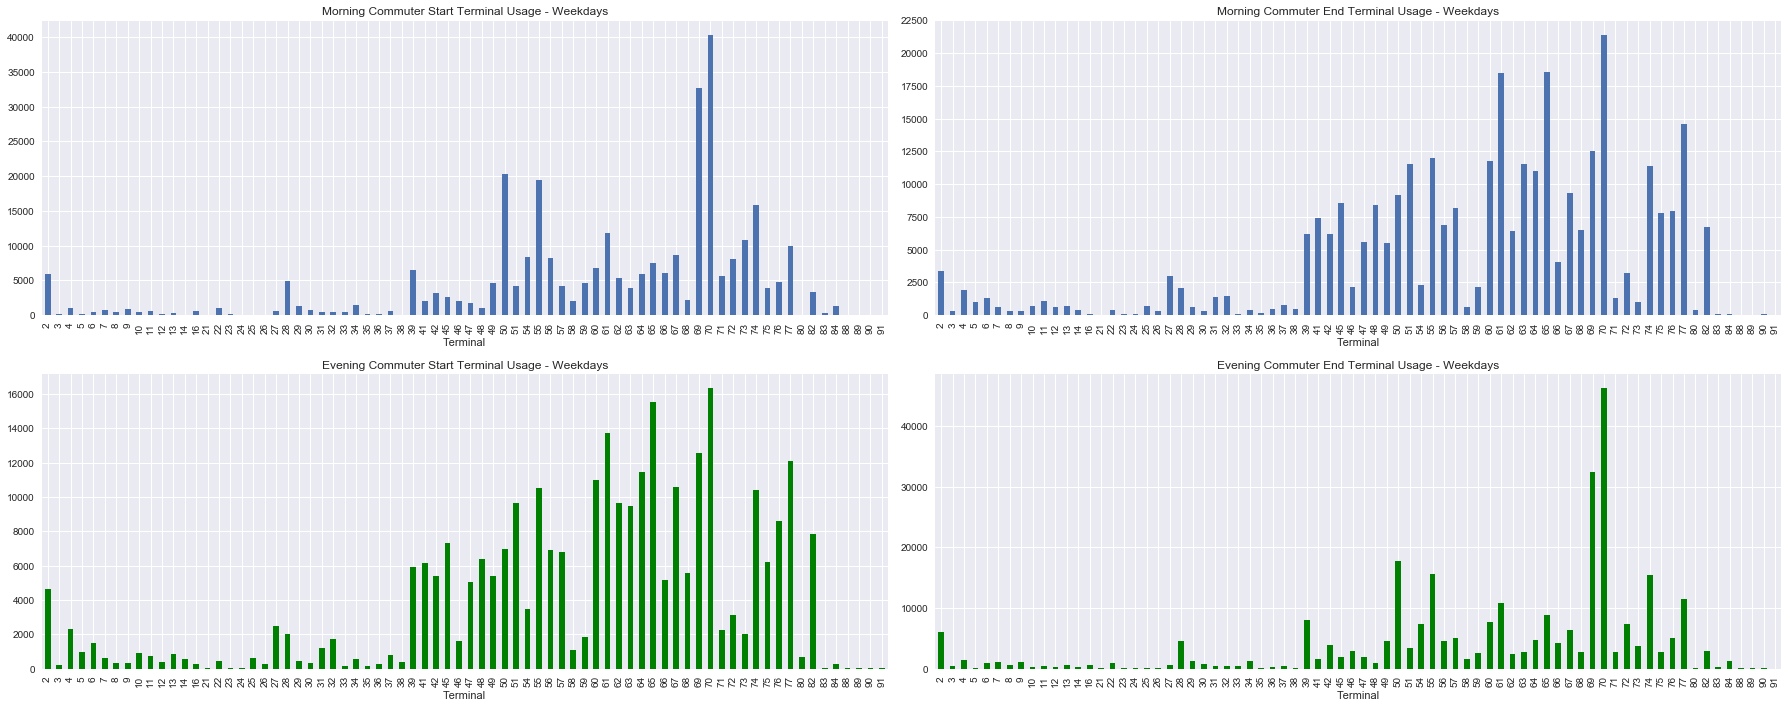

In [31]:
plt.subplot(2, 2, 1)
top_am_commute_start_terms = weekday_am_commuters.groupby('start_terminal')['bike_id'].count()
top_10_am_commute_start_terms = weekday_am_commuters.groupby('start_terminal')['bike_id'].count().sort_values(ascending=False).head(10)
print('Morning Commuter Start Terminal Usage - Weekdays\t', top_10_am_commute_start_terms.index)
top_am_commute_start_terms.plot(kind='bar',figsize=(25,10))
plt.xlabel('Terminal')
plt.title('Morning Commuter Start Terminal Usage - Weekdays')

plt.subplot(2, 2, 2)
top_am_commute_end_terms = weekday_am_commuters.groupby('end_terminal')['bike_id'].count()
top_10_am_commute_end_terms = weekday_am_commuters.groupby('end_terminal')['bike_id'].count().sort_values(ascending=False).head(10)
print('Morning Commuter End Terminal Usage - Weekdays\t\t', top_10_am_commute_end_terms.index)
top_am_commute_end_terms.plot(kind='bar')
plt.xlabel('Terminal')
plt.title('Morning Commuter End Terminal Usage - Weekdays')


plt.subplot(2, 2, 3)
top_pm_commute_start_terms = weekday_pm_commuters.groupby('start_terminal')['bike_id'].count()
top_10_pm_commute_start_terms = weekday_pm_commuters.groupby('start_terminal')['bike_id'].count().sort_values(ascending=False).head(10)
print('Evening Commuter Start Terminal Usage - Weekdays\t', top_10_pm_commute_start_terms.index)
top_pm_commute_start_terms.plot(kind='bar', color='g')
plt.xlabel('Terminal')
plt.title('Evening Commuter Start Terminal Usage - Weekdays')

plt.subplot(2, 2, 4)
top_pm_commute_end_terms = weekday_pm_commuters.groupby('end_terminal')['bike_id'].count()
top_10_pm_commute_end_terms = weekday_pm_commuters.groupby('end_terminal')['bike_id'].count().sort_values(ascending=False).head(10)
print('Evening Commuter End Terminal Usage - Weekdays\t\t', top_10_pm_commute_end_terms.index)
top_pm_commute_end_terms.plot(kind='bar', color='g')
plt.xlabel('Terminal')
plt.title('Evening Commuter End Terminal Usage - Weekdays')

plt.tight_layout()
plt.show()

# Popular stations for Subscribers - Weekends

Subscriber Weekend Start Terminal Usage	 Int64Index([70, 69, 55, 50, 61, 74, 65, 77, 60, 67], dtype='int64', name='start_terminal')
Subscriber Weekend End Terminal Usage	 Int64Index([70, 69, 61, 50, 77, 65, 55, 74, 60, 67], dtype='int64', name='end_terminal')


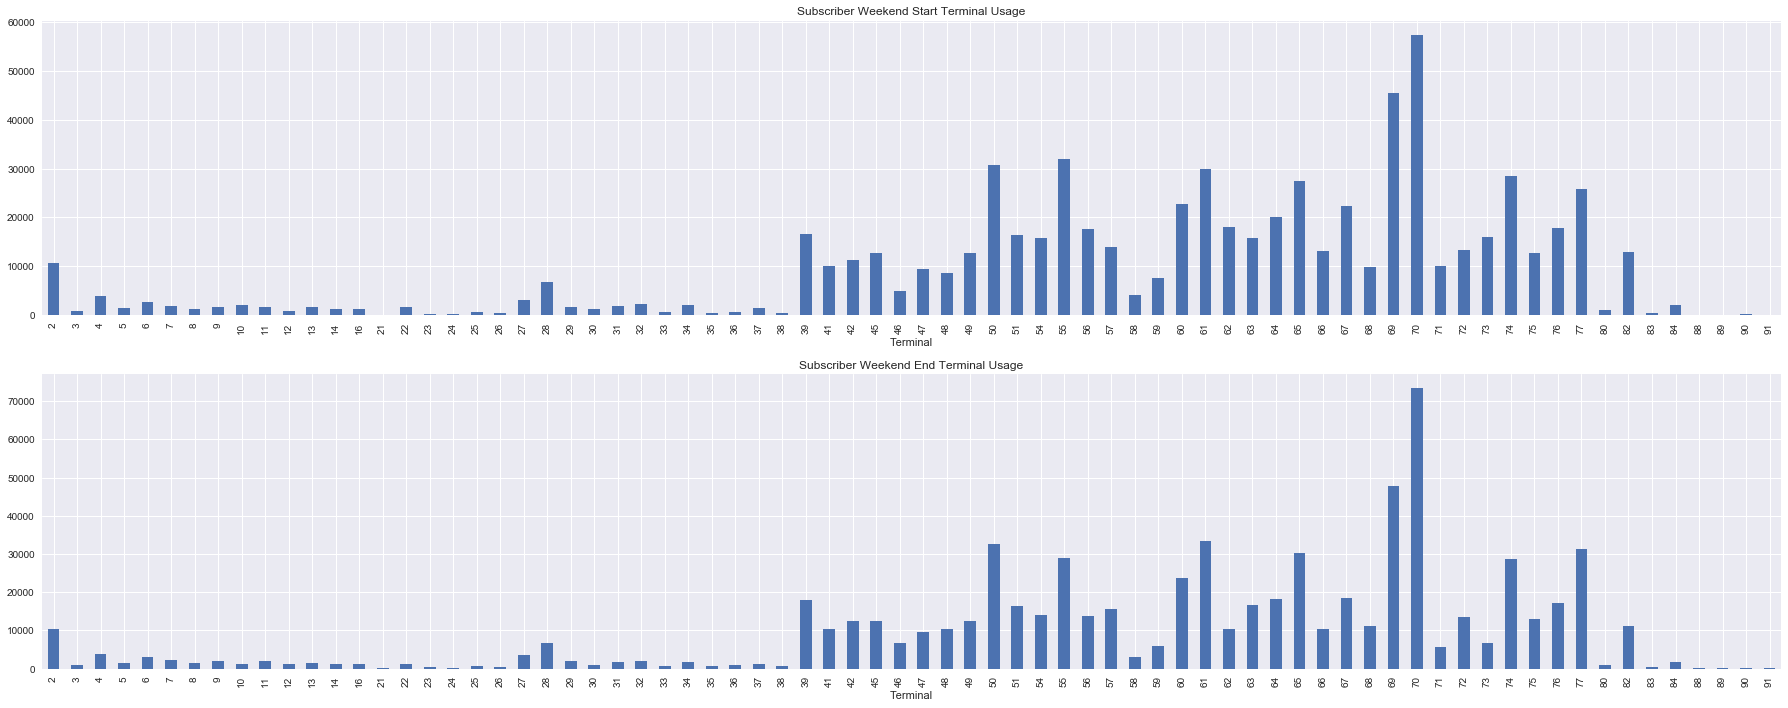

In [32]:

prune_subscriber_weekend_trips

plt.subplot(2, 1, 1)
subsciber_weekend_start_terms = prune_subscriber_weekend_trips.groupby('start_terminal')['bike_id'].count()
top_10_subsciber_weekend_start_terms = prune_subscriber_weekend_trips.groupby('start_terminal')['bike_id'].count().sort_values(ascending=False).head(10)
print('Subscriber Weekend Start Terminal Usage\t', top_10_subsciber_weekend_start_terms.index)
subsciber_weekend_start_terms.plot(kind='bar',figsize=(25,10))
plt.xlabel('Terminal')
plt.title('Subscriber Weekend Start Terminal Usage')


plt.subplot(2, 1, 2)
subsciber_weekend_end_terms = prune_subscriber_weekend_trips.groupby('end_terminal')['bike_id'].count()
top_10_subsciber_weekend_end_terms = prune_subscriber_weekend_trips.groupby('end_terminal')['bike_id'].count().sort_values(ascending=False).head(10)
print('Subscriber Weekend End Terminal Usage\t', top_10_subsciber_weekend_end_terms.index)
subsciber_weekend_end_terms.plot(kind='bar')
plt.xlabel('Terminal')
plt.title('Subscriber Weekend End Terminal Usage')

plt.tight_layout()
plt.show()

# Popular stations for Customers

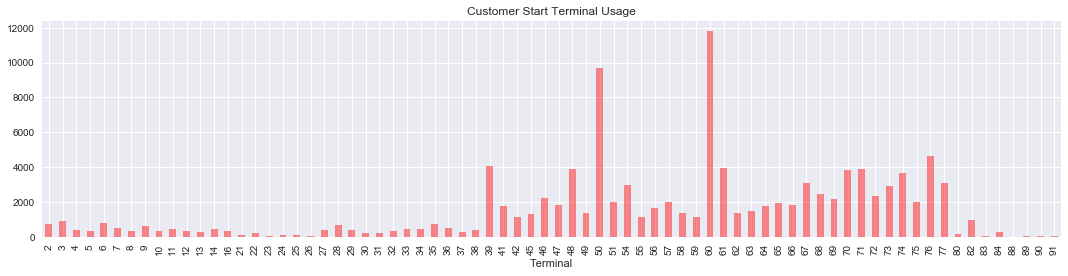

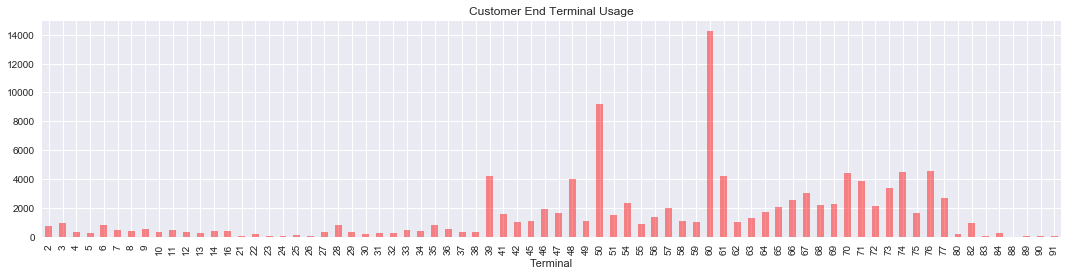

In [33]:

# plt.subplot(2, 1, 1)
top_customer_start_terms = customer_trips.groupby('start_terminal')['bike_id'].count()
top_customer_start_terms.plot(kind='bar', color='r', alpha=0.45,figsize=(15,4))
plt.xlabel('Terminal')
plt.title('Customer Start Terminal Usage')
plt.tight_layout()
plt.show()


# plt.subplot(2, 1, 2)
top_customer_end_terms = customer_trips.groupby('end_terminal')['bike_id'].count()
top_customer_end_terms.plot(kind='bar', color='r', alpha=0.45,figsize=(15,4))
plt.xlabel('Terminal')
plt.title('Customer End Terminal Usage')
plt.tight_layout()
plt.show()